# Table of contents

[Trial-wise cluster, joint-trial filter fit](#joint_filter)

[Trial-to-trial corr analysis](#t2t_analysis)

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import networkx as nx
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.1.1
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [4]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [5]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [6]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

#### Fine Time Coupling Model

In [7]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [118]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261,
#                  278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261,
#                  286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989

In [9]:
condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  246 temp freq [15.0] orient [0.0] contrast [0.8] [ 3798  3852  3947  3966  3979 31016 31026 31160 31186 49206 49245 49346 49372 49409 49412]
1  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
2  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
3  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
4  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
5  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
6  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275

## Spike Trains

In [14]:
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


In [15]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 285)

# Load previous xorr analysis.

In [160]:
graph_file = project_dir + 'Output/network/798911424_condition5_area6_active.pkl'
graph = nx.read_gpickle(graph_file)

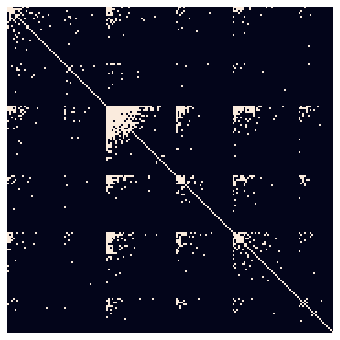

In [161]:
model.plot_adj_mat(graph)

In [192]:
nodes_group = model.group_sort_nodes_by_attr(graph, 'probe', 'degree')
display(nodes_group['probeC'])
display(nodes_group['probeD'])

[(951103332, {'probe': 'probeC', 'degree': 62}),
 (951104192, {'probe': 'probeC', 'degree': 58}),
 (951103958, {'probe': 'probeC', 'degree': 53}),
 (951103632, {'probe': 'probeC', 'degree': 40}),
 (951104031, {'probe': 'probeC', 'degree': 28}),
 (951103262, {'probe': 'probeC', 'degree': 27}),
 (951103361, {'probe': 'probeC', 'degree': 26}),
 (951104064, {'probe': 'probeC', 'degree': 24}),
 (951102686, {'probe': 'probeC', 'degree': 22}),
 (951102673, {'probe': 'probeC', 'degree': 22}),
 (951103877, {'probe': 'probeC', 'degree': 20}),
 (951102623, {'probe': 'probeC', 'degree': 16}),
 (951102962, {'probe': 'probeC', 'degree': 16}),
 (951103704, {'probe': 'probeC', 'degree': 16}),
 (951102834, {'probe': 'probeC', 'degree': 13}),
 (951103934, {'probe': 'probeC', 'degree': 11}),
 (951103498, {'probe': 'probeC', 'degree': 9}),
 (951103918, {'probe': 'probeC', 'degree': 7}),
 (951103238, {'probe': 'probeC', 'degree': 6}),
 (951103093, {'probe': 'probeC', 'degree': 5}),
 (951103652, {'probe': '

[(951109435, {'probe': 'probeD', 'degree': 35}),
 (951109137, {'probe': 'probeD', 'degree': 25}),
 (951109118, {'probe': 'probeD', 'degree': 25}),
 (951109319, {'probe': 'probeD', 'degree': 21}),
 (951109282, {'probe': 'probeD', 'degree': 18}),
 (951108911, {'probe': 'probeD', 'degree': 8}),
 (951109213, {'probe': 'probeD', 'degree': 7}),
 (951109307, {'probe': 'probeD', 'degree': 6}),
 (951109184, {'probe': 'probeD', 'degree': 5}),
 (951109702, {'probe': 'probeD', 'degree': 5}),
 (951110067, {'probe': 'probeD', 'degree': 3}),
 (951108685, {'probe': 'probeD', 'degree': 2}),
 (951108867, {'probe': 'probeD', 'degree': 2}),
 (951108877, {'probe': 'probeD', 'degree': 2}),
 (951109423, {'probe': 'probeD', 'degree': 2}),
 (951108557, {'probe': 'probeD', 'degree': 1}),
 (951108633, {'probe': 'probeD', 'degree': 1}),
 (951109191, {'probe': 'probeD', 'degree': 1}),
 (951109291, {'probe': 'probeD', 'degree': 1}),
 (951109329, {'probe': 'probeD', 'degree': 1}),
 (951108540, {'probe': 'probeD', 'd

# Fit individual filter + raw filter clustering.

In [19]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [20]:
# a = stimulus_table['stimulus_condition_id'].unique(); b = np.setdiff1d(a,select_condition_ids)
# [247, 248, 250, 251, 252, 253, 254, 255, 259, 262, 264, 266, 269, 271, 272, 276, 277, 279, 282, 283, 285]
select_condition_ids = [275, 246, 268, 270, 284, 274,  249, 263, 265, 261, 286, 258,  278, 267, 280, 256, 260, 257, 281]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

### Within probes.

In [18]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=False)
probe_pairs = [('probeE', 'probeC')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_probe = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=False)

num_pairs: 756


In [196]:
model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.8, 'max_num_itrs': 40, 'epsilon': 1e-5}
model_list = model.each_pair_all_trials_bivariate_regression(filter_membership_probe, 'neuron', model_par, group_ids=[0], verbose=False)

100%|█████████████████████████████████████████████████████████████| 756/756 [06:21<00:00,  1.98it/s]


In [197]:
file_path = project_dir + 'Output/fig/AL_V1_within_probe_alltrials_filter.pdf'
model.plot_model_list_checkerboard(model_list, file_path=None)

Save figure to: D:/Brain_Network/Output/fig/AL_V1_within_probe_alltrials_filter.pdf


### Between probes.

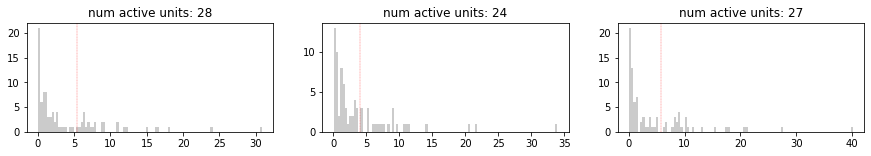

num_pairs: 672
num_pairs: 648


In [15]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

In [651]:
# neuron_pairs = [(951103332, 951109435), (951103332, 951109137), (951103332, 951109118)]
neuron_pairs = filter_membership_CD.append(filter_membership_DE)
model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}
model_list = model.each_pair_all_trials_bivariate_regression(neuron_pairs, model_par, verbose=False)

100%|███████████████████████████████████████████████████████████| 1320/1320 [09:24<00:00,  2.34it/s]


### Filter clustering.

num_models 1320 num non-nuisance beta 9
outlier_cnt 0
cluster membership cnt [(5, 299), (7, 169), (0, 166), (13, 116), (1, 108), (11, 105), (3, 105), (4, 70), (2, 52), (6, 43), (8, 42), (14, 36), (10, 4), (9, 4), (12, 1)]


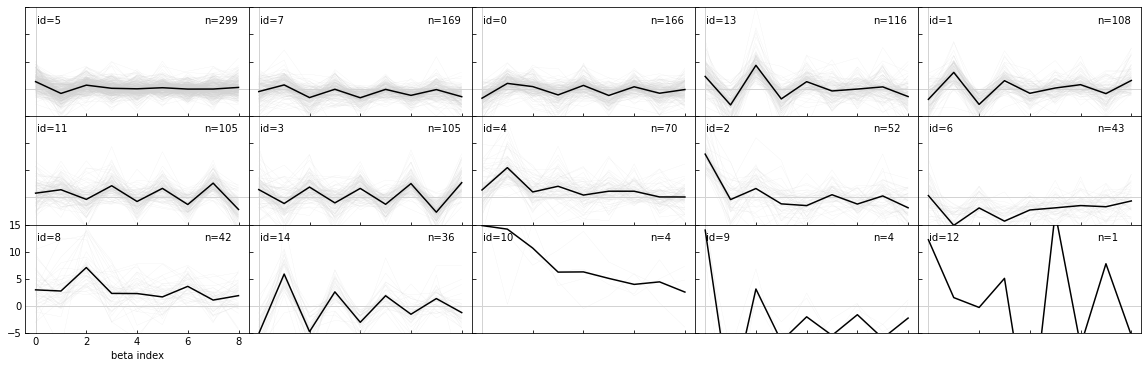

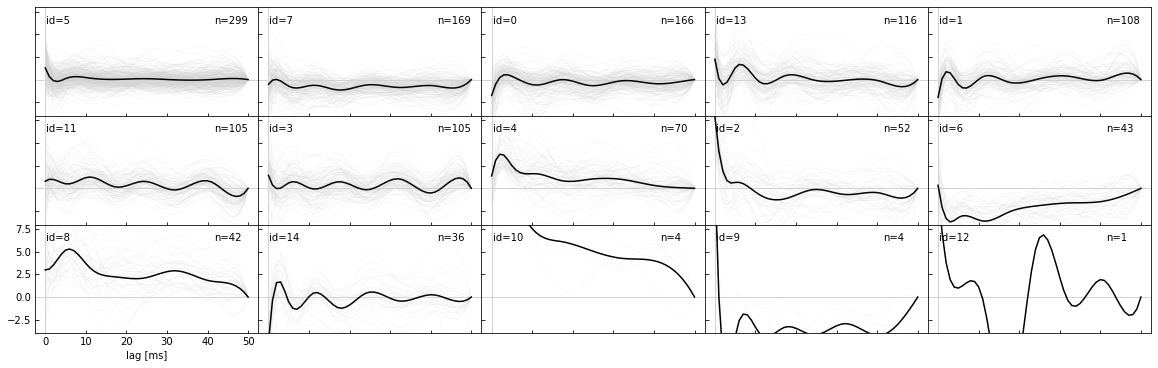

In [657]:
filter_membership_init, beta_mat, filter_t, filter_mat = model.cfpp_clustering(model_list, num_clusters=15)
file_path = project_dir + 'Output/fig/raw_filter_clustering.pdf'
model.plot_filter_clusters(model_list, filter_membership_init, beta_mat, filter_t, filter_mat,
                           num_rows_cols=(3, 5), file_path=None)

cluster membership cnt [(0, 465), (3, 283), (7, 169), (4, 168), (11, 105), (2, 47), (1, 46), (14, 36), (12, 1)]


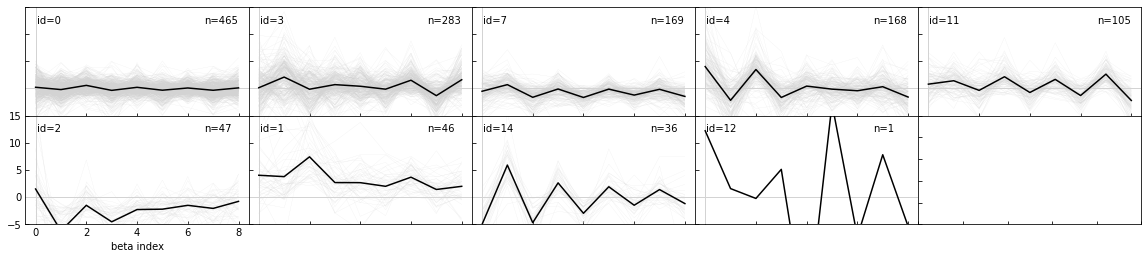

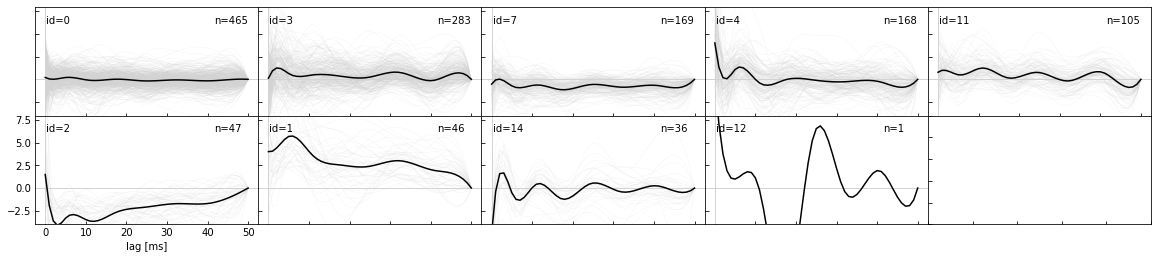

In [658]:
# Switch orders.
# map_raw_new_order = {2:0, 5:1, 1:2, 6:3, 4:4, 3:4, 7:5, 0:6,}
map_raw_new_order = {5:0, 8:1, 10:1, 9:2, 6:2, 1:3, 4:3, 2:4, 13:4}
filter_membership_reorder = model.relabel_clusters(filter_membership_init, map_raw_new_order, verbose=True)
model.plot_filter_clusters(model_list, filter_membership_reorder, beta_mat, filter_t, filter_mat, 
                           num_rows_cols=(2,5), file_path=None)

### Test for each group.

In [1512]:
cluster_cnt = filter_membership.value_counts()
cluster_cnt = [(idx[0], cluster_cnt[idx]) for idx in cluster_cnt.index]
print('cluster membership cnt', cluster_cnt)

cluster membership cnt [(1.0, 109), (2.0, 91), (3.0, 50), (4.0, 44), (0.0, 42)]


In [1056]:
# Single trial test.
# filter_membership_test = filter_membership_CD.iloc[:,[1]]
# spike_times_x, spike_times_y = model.stack_spike_times_by_pairs(spike_times, filter_membership_test, group_id=1, batch_size=None)
# Multiple trial test.
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
spike_times_x, spike_times_y = model.stack_spike_times_by_pairs(spike_times, filter_membership_joint, group_id=1, batch_size=500)

#all:1883	#batch:500


layers 2, nodes 1, trials 19
meanFR 14.789 meanISI 19.929


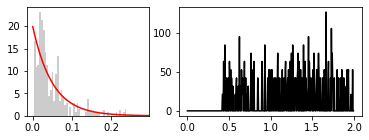

layers 2, nodes 1, trials 19
meanFR 13.263 meanISI 17.12


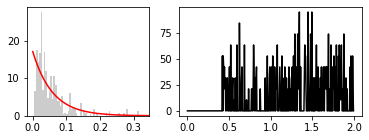

In [1054]:
jittertool.spike_times_statistics(spike_times_x, trial_window[1], verbose=1)
jittertool.spike_times_statistics(spike_times_y, trial_window[1], verbose=1)

In [1559]:
model_par = {'filter_type': 'square', 'filter_length': 0.05,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 20, 'epsilon': 1e-5}
model_par_hat12 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_time_window, model_par)
# model_par_hat21 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_y, spike_times_x, trial_length, model_par)

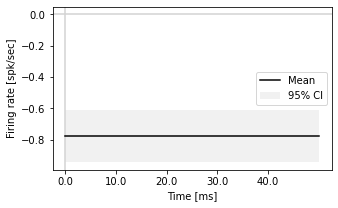

In [1560]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat12, ylim=None)
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat21, ylim=[-5, 5])

### Fit each cluster.

In [1425]:
group_model_pars = model.update_cluster_filter(filter_membership, verbose=False)

In [687]:
file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
# file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition12/group_model_pars_DE_trial49274_itr4_20210429-203956.pkl'
group_model_pars = util.load_variable(file_path)

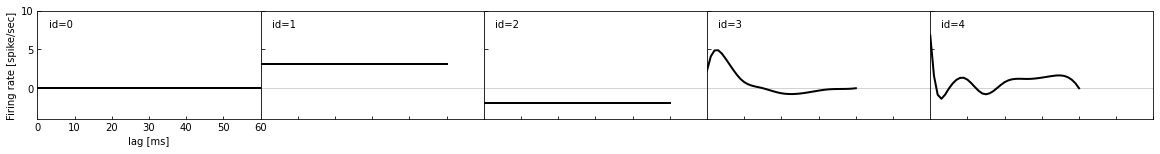

In [688]:
file_path = project_dir + 'Output/fig/filter_grups.pdf'
model.plot_multiple_filters(group_model_pars, num_rows_cols=[1,5], ylim=[-4, 10], file_path=None)

Save cluster template.

In [1446]:
file_path = project_dir + 'Output/jitter/group_model_pars_group5.pkl'
# util.save_variable(file_path, group_model_pars)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/group_model_pars_group5.pkl


### Re-assign each pair.

In [1436]:
x = model.update_filter_membership(group_model_pars, filter_membership, verbose=True)

  0%|                                                                       | 0/152 [00:00<?, ?it/s]D:/Brain_Network/Code\jitter.py:3611: RuntimeWarning: overflow encountered in square
  delta = np.linalg.inv(hessian) @ gradient
 11%|██████▌                                                       | 16/152 [00:19<03:16,  1.44s/it]D:/Brain_Network/Code\jitter.py:3614: RuntimeWarning: overflow encountered in matmul
  # Check convergence.
D:/Brain_Network/Code\jitter.py:3614: RuntimeWarning: invalid value encountered in matmul
  # Check convergence.
 38%|███████████████████████▋                                      | 58/152 [00:55<01:16,  1.22it/s]D:/Brain_Network/Code\jitter.py:3606: RuntimeWarning: overflow encountered in matmul
  
D:/Brain_Network/Code\jitter.py:3608: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:3608: RuntimeWarning: invalid value encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient

In [1442]:
model.plot_filter_clusters(model_list, x, beta_mat, filter_t, filter_mat, num_rows_cols=(2,4))

In [1440]:
cluster_cnt = filter_membership.value_counts()
cluster_cnt = [(idx[0], cluster_cnt[idx]) for idx in cluster_cnt.index]
print('cluster membership cnt', cluster_cnt)

cluster_cnt = x.value_counts()
cluster_cnt = [(idx[0], cluster_cnt[idx]) for idx in cluster_cnt.index]
print('cluster membership cnt', cluster_cnt)

cluster membership cnt [(0, 53), (3, 31), (2, 29), (4, 24), (1, 15)]
cluster membership cnt [(2, 47), (1, 46), (3, 22), (4, 19), (0, 18)]


In [ ]:
# Load an example filter membership.
file_path = project_dir + 'Output/jitter/filter_membership_group5_test.pkl'
# filter_membership = util.load_variable(file_path)

# Trial-wise neuron cluster, joint-trial group filter fit.
Cluster neurons for each trial. Pull all trials all neurons together to fit the filter.

In [106]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [107]:
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
# select_condition_ids = [275, 246, 268, 270]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

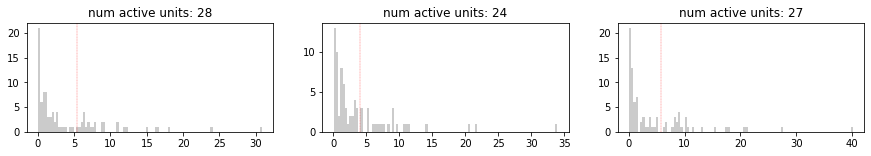

num_pairs: 672
num_pairs: 648


In [108]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [126]:
model.check_empty_trials(spike_times, active_units)

951102476 90
951102646 133
951102686 0
951102962 1
951102820 92
951103019 124
951103093 3
951103163 2
951103150 26
951103361 0
951103290 56
951103262 0
951103238 0
951103332 2
951103380 2
951103498 0
951103488 19
951103530 0
951103632 50
951103624 3
951103508 2
951103652 0
951103958 5
951103704 1
951103877 5
951104031 6
951103918 63
951104192 0

951108540 21
951108557 9
951108685 7
951108721 3
951108867 34
951110003 8
951108877 1
951108911 1
951109006 27
951109184 1
951109137 0
951109213 5
951109118 29
951109191 3
951109262 5
951109299 4
951109282 0
951109307 19
951109338 26
951109329 17
951109319 0
951109435 19
951109594 81
951109702 37

951112464 1
951112448 6
951112431 20
951112416 3
951112479 6
951112638 18
951112590 35
951112712 0
951112786 10
951112780 90
951112768 0
951112845 3
951112906 3
951112937 28
951112992 0
951113075 0
951113056 25
951113039 22
951113191 0
951113175 0
951113141 7
951113271 0
951113211 0
951113240 7
951113464 2
951113514 10
951113717 11



In [ ]:
Diag neuron: 951108540 233
Diag neuron: 951108867 553
Diag neuron: 951109006 432
Diag neuron: 951109118 489
Diag neuron: 951109307 171
Diag neuron: 951109338 374
Diag neuron: 951109329 121
Diag neuron: 951109435 222
Diag neuron: 951109594 750
Diag neuron: 951109702 584

In [ ]:
951102476 951112780 78
951102646 951112638 39
951102646 951112780 269
951102646 951112937 34
951102646 951113056 38
951102646 951113039 70
951102820 951112780 93
951103019 951112780 190

#### Load filter templates.

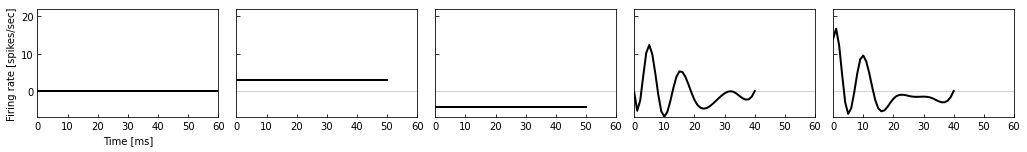

In [21]:
# file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/group_model_pars_joint_itr149_20210523-071613.pkl'
group_model_pars = util.load_variable(file_path)
model.plot_multiple_filters(group_model_pars, ylim=[-7, 22], num_rows_cols=[1,5])

#### Load cluster templates. (optional)

In [25]:
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr149_20210523-070711.pkl'
filter_membership_CD = util.load_variable(file_path)
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr149_20210523-070711.pkl'
filter_membership_DE = util.load_variable(file_path)
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
model.filter_membership_statistics(filter_membership_CD, verbose=True)
model.filter_membership_statistics(filter_membership_DE, verbose=True)
model.filter_membership_statistics(filter_membership_joint, verbose=True)
group_portion = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

filter_membership.shape (672, 285)
membership cnt [(0.0, 40236), (1.0, 46840), (2.0, 51476), (3.0, 27561), (4.0, 25407)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 31261), (1.0, 49864), (2.0, 45456), (3.0, 29902), (4.0, 28197)]
filter_membership.shape (1320, 285)
membership cnt [(0.0, 71497), (1.0, 96704), (2.0, 96932), (3.0, 57463), (4.0, 53604)]


#### Select the smoothing kernel width using plug-in estimator (with sub-sampling).

#all trials:71497	#batch trials:3000
optimal kernel width  60.0


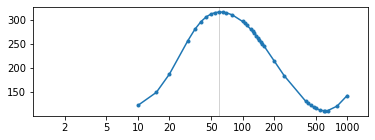

optimal kernel width  40.0


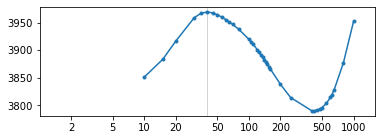

optimal kernel width  70.0


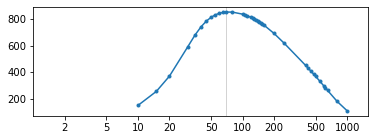

optimal kernel width  55.0


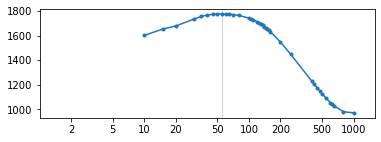

optimal kernel width  10.0


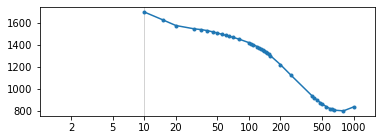

In [64]:
model.estimate_nuisance_kernel_width_by_group(filter_membership_joint)

#all trials:376200	#batch trials:5000
optimal kernel width  60.0


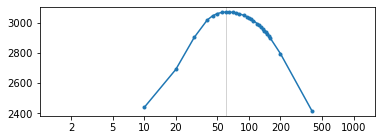

optimal kernel width  250.0


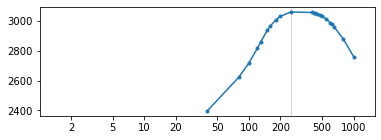

In [77]:
model.estimate_nuisance_kernel_width_together(filter_membership_joint)

### Serial programming.

In [228]:
filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
group_portion = model.update_membership_portion(5, filter_membership_joint)

In [17]:
z_CD = filter_membership_CD.iloc[:,:2]
for trial_id in tqdm(selected_trial_ids, ncols=100):
    trial_ids = [trial_id]
    z_tmp = model.update_filter_membership(spike_times, trial_window, group_portion, group_model_pars, z_CD, trial_ids, verbose=False)

 23%|██████████████▋                                                | 14/60 [00:16<00:56,  1.23s/it]D:/Brain_Network/Code\jitter.py:3864: RuntimeWarning: overflow encountered in square
  hessian = X[non_zero_ind].T @ (X[non_zero_ind] / np.square(lmbd[non_zero_ind]))
 28%|█████████████████▊                                             | 17/60 [00:19<00:52,  1.22s/it]D:/Brain_Network/Code\jitter.py:3867: RuntimeWarning: invalid value encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
 72%|█████████████████████████████████████████████▏                 | 43/60 [00:51<00:21,  1.27s/it]D:/Brain_Network/Code\jitter.py:3867: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
D:/Brain_Network/Code\jitter.py:3879: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
100%|███████████████████████████████████████████████████████████████| 60/60 [01:15<00:00,  1.26s/it]


In [ ]:

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/group_model_pars_joint_itr29_20211113_102001.pkl'
group_model_pars = util.load_variable(file_path)

# output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/'

for trial_id in tqdm(selected_trial_ids, ncols=100):
    trial_ids = [trial_id]
    _ = model.update_filter_membership(spike_times, trial_window, group_portion, group_model_pars, 
                                       filter_membership_CD, [trial_id], parallel=True)

#     filter_membership_CD = model.update_filter_membership(spike_times, trial_window, group_portion, group_model_pars, 
#                                                            filter_membership_CD, [trial_id], parallel=True)
#     filter_membership_DE = model.update_filter_membership(spike_times, trial_window, group_portion, group_model_pars, 
#                                                           filter_membership_DE, [trial_id], parallel=True)

# model.filter_membership_statistics(filter_membership_CD)
# model.filter_membership_statistics(filter_membership_DE)
# file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, filter_membership_CD)
# file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, filter_membership_DE)

# filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
# group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, batch_training=False, verbose=False)
# model.plot_multiple_filters(group_model_pars, ylim=[-6, 18], num_rows_cols=[1,5])
# file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, group_model_pars)

### Parallel programming.

In [248]:
file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
group_model_pars = util.load_variable(file_path)
output_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/'

itr = 0
jobs_CD, jobs_DE = [], []
for trial_id in selected_trial_ids:
    job1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                   filter_membership_CD, [trial_id], parallel=True)
    job2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_portion, group_model_pars, 
                                                   filter_membership_DE, [trial_id], parallel=True)
    jobs_CD.append(job1)
    jobs_DE.append(job2)
with Parallel(n_jobs=5, verbose=55) as parallel_pool:
    jobs_CD_out = parallel_pool(jobs_CD)
    jobs_DE_out = parallel_pool(jobs_DE)
filter_membership_CD = pd.concat(jobs_CD_out, axis=1)
filter_membership_DE = pd.concat(jobs_DE_out, axis=1)

model.filter_membership_statistics(filter_membership_CD)
model.filter_membership_statistics(filter_membership_DE)

# file_path = output_dir + f'filter_membership_CD_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, filter_membership_CD)
# file_path = output_dir + f'filter_membership_DE_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, filter_membership_DE)

# filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
# group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, batch_training=False, verbose=False)
# model.plot_multiple_filters(group_model_pars, ylim=[-6, 18], num_rows_cols=[1,5])
# file_path = output_dir + f'group_model_pars_joint_itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl'
# util.save_variable(file_path, group_model_pars)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   17.4s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   18.3s remaining:   27.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   18.6s remaining:   12.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   19.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   14.8s remaining:   22.2s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   16.5s finished
filter_membership.shape (672, 5)
membership cnt [(0.0, 766), (1.0, 819), (2.0, 750), (3.0, 401), (4.0, 624)]

[(0.0, 30163), (1.0, 48425), (2.0, 45464), (3.0, 26563), (4.0, 34065)]

# Results: Trial-to-trial corr analysis.

Save figure to: D:/Brain_Network/Output/fig/session791319847_CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_20211227_100628_group_model_pars.pdf


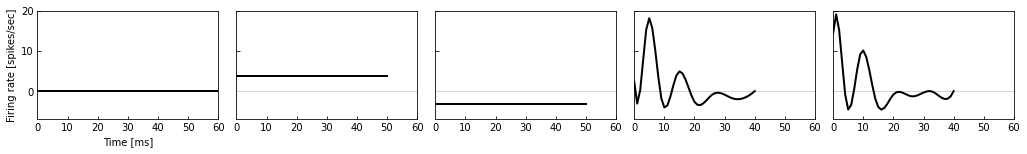

In [47]:
# model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/group_model_pars_joint_itr29_20211113_102001.pkl'
# model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_emptynan_12182021_2051/group_model_pars_joint_itr14_20211220_075823.pkl'
# model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel80ms_11242021_1717/group_model_pars_joint_itr29_20211125_114312.pkl'
# model_path = project_dir + 'Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/group_model_pars_joint_itr25_20211128_131855.pkl'
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_emptynan_12262021_2137/group_model_pars_joint_itr14_20211227_100628.pkl'

group_model_pars = util.load_variable(model_path)
# file_path = project_dir + 'Output/fig/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_20211220_075823_group_model_pars.pdf'
file_path = project_dir + 'Output/fig/session791319847_CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_20211227_100628_group_model_pars.pdf'
model.plot_multiple_filters(group_model_pars, ylim=[-7, 20], num_rows_cols=[1,5], file_path=file_path)

##### Plot training results per iteration.

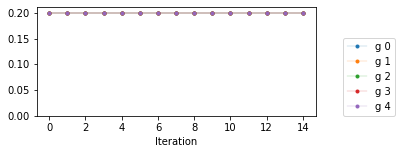

In [23]:
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'  # 0.20,0.20,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel55ms_11262021_2255/'  # 0.20,0.20,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel80ms_11242021_1717/'  # 0.20,0.20,0.20,0.20,0.20
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_emptynan_12182021_2051/'  # 0.20,0.20,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11132021/'  # 0.15,0.25,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021/'  # 0.25,0.15,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021_1923/'  # 0.15,0.20,0.25,0.20,0.20

itrs = np.arange(0, 200)
prefix = 'group_portion'
model.plot_filter_membership_sample_trace(model_dir, prefix, itrs)

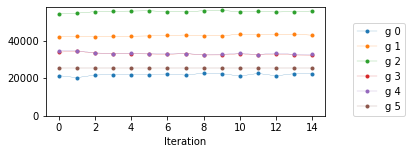

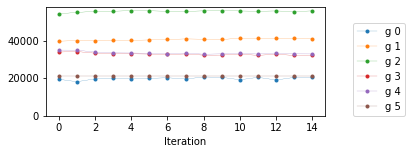

In [42]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_emptynan_12262021_2137/'

prefix = 'filter_membership_CD'
model.plot_filter_membership_sample_trace(model_dir, prefix, itrs=np.arange(200))
prefix = 'filter_membership_DE'
model.plot_filter_membership_sample_trace(model_dir, prefix, itrs=np.arange(200))

##### Load individual cluster, joint filter fit.

In [55]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_randomempty_12182021_1151/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_emptynan_12182021_2051/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel50ms_emptynan_12242021_1417/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_emptynan_12252021_1445/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_uneven_portion2520152020_kernel60ms_emptynan_12252021_1931/'  # 0.25,0.20,0.15,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_uneven_portion2025152020_kernel60ms_emptynan_12252021_2249/'  # 0.25,0.20,0.15,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11132021/'  # 0.15,0.25,0.20,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021/'  # 0.25,0.15,0.25,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_uneven_11142021_1923/'  # 0.15,0.20,0.25,0.20,0.20
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel80ms_11242021_1717/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel50ms_11252021_0828/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_kernel100ms_11252021_2242/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel55ms_11262021_2255/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition21_joint_fit_fixed_portion_kernel60ms_emptynan_12262021_2137/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session791319847_CD_DE_condition19_joint_fit_fixed_portion_kernel70ms_11272021_2248/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session757216464_CD_DE_condition20_joint_fit_fixed_portion_kernel20ms_11282021_0952/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session762120172_CD_DE_condition21_joint_fit_fixed_portion_kernel40ms_11282021_1400/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session762120172_CD_DE_condition24_joint_fit_fixed_portion_kernel40ms_11282021_1540/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session732592105_CD_DE_condition23_joint_fit_fixed_portion_kernel20ms_11282021_1840/'  # 0.20 x5
# model_dir = project_dir + 'Output/jitter/coupling_filter/session755434585_CD_DE_condition24_joint_fit_fixed_portion_kernel20ms_11282021_2128/'  # 0.20 x5

file_path = model_dir + 'filter_membership_CD_itr29_20211113_100406.pkl'
filter_membership_CD = util.load_variable(file_path)
file_path = model_dir + 'filter_membership_DE_itr29_20211113_100406.pkl'
filter_membership_DE = util.load_variable(file_path)

filter_membership_joint = filter_membership_CD.append(filter_membership_DE)
_=model.filter_membership_statistics(filter_membership_CD, verbose=True)
_=model.filter_membership_statistics(filter_membership_DE, verbose=True)
_=model.filter_membership_statistics(filter_membership_joint, verbose=True)

filter_membership.shape (672, 285)
membership cnt [(0.0, 44863), (1.0, 39015), (2.0, 49584), (3.0, 28984), (4.0, 29074)]
filter_membership.shape (648, 285)
membership cnt [(0.0, 34628), (1.0, 36494), (2.0, 50835), (3.0, 30905), (4.0, 31818)]
filter_membership.shape (1320, 285)
membership cnt [(0.0, 79491), (1.0, 75509), (2.0, 100419), (3.0, 59889), (4.0, 60892)]


filter_membership.shape (672, 315)
membership cnt [(0.0, 22483.0), (1.0, 42902.0), (2.0, 55772.0), (3.0, 32269.0), (4.0, 32662.0), (nan, 25592.0)]
save figure: D:/Brain_Network/Output/fig/798911424_filter_type_hist_V1_LM_emptynan_kernel_60ms_condition21.pdf


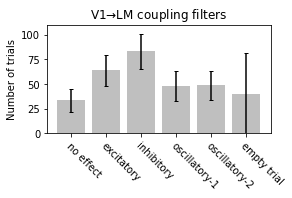

filter_membership.shape (648, 315)
membership cnt [(0.0, 20508.0), (1.0, 41190.0), (2.0, 56033.0), (3.0, 32202.0), (4.0, 33025.0), (nan, 21162.0)]
save figure: D:/Brain_Network/Output/fig/798911424_filter_type_hist_LM_AL_emptynan_kernel_60ms_condition21.pdf


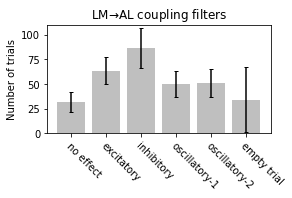

In [46]:
title=r'V1$\to$LM coupling filters'
file_path = project_dir + f'Output/fig/{session_id}_filter_type_hist_V1_LM_emptynan_kernel_60ms_condition21.pdf'
_=model.filter_membership_statistics(filter_membership_CD, ylim=[0, 110], title=title, file_path=file_path, verbose=2)

title=r'LM$\to$AL coupling filters'
file_path = project_dir + f'Output/fig/{session_id}_filter_type_hist_LM_AL_emptynan_kernel_60ms_condition21.pdf'
_=model.filter_membership_statistics(filter_membership_DE, ylim=[0, 110], title=title, file_path=file_path, verbose=2)

#### Pairwise correlation analysis.

In [18]:
contingency_mat, chi2t_df, pval_df = model.calculate_filter_memberships_corr(filter_membership_CD, filter_membership_DE, verbose=True)

100%|█████████████████████████████████████████████████████████████| 672/672 [01:45<00:00,  6.38it/s]


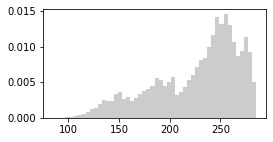

In [30]:
model.plot_statistics_contingency_tables(contingency_mat)

Total sample size 435456
p-val		cnt	portion
p-val<0.01:	4320	9.92e-03
p-val<0.001:	451	1.04e-03
p-val<0.0001:	51	1.17e-04
p-val<1e-05:	9	2.07e-05
p-val<1e-06:	1	2.30e-06
FDR BY
alpha<0.05:	0
alpha<0.01:	0
FWER Bonferroni
alpha<0.05:	0
alpha<0.01:	0
Save figure to: D:/Brain_Network/Output/fig/session755434585_condtion24_filter_type_corr_FDRBY_V1broadcast_ALreceiver_fixed_portion_kernel20ms_11282021_2128.png


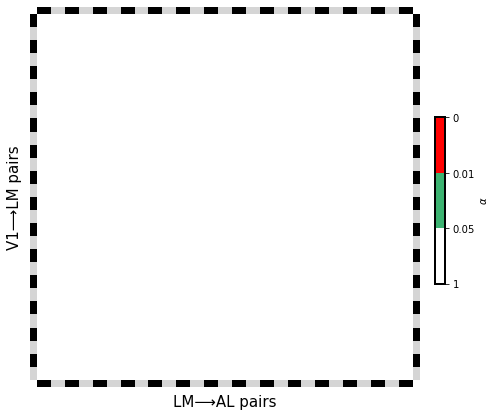

In [19]:
file_path = project_dir + 'Output/fig/session755434585_condtion24_filter_type_corr_FDRBY_V1broadcast_ALreceiver_fixed_portion_kernel20ms_11282021_2128.png'
# model.plot_filter_memberships_corr(contingency_mat, chi2t_df, pval_df)
# model.plot_filter_memberships_corr_beautiful(contingency_mat, chi2t_df, pval_df,level_order='01', multitest_method=None, file_path=file_path)
model.plot_filter_memberships_corr_beautiful(contingency_mat, chi2t_df, pval_df,level_order='01', multitest_method='fdr_by', file_path=file_path)


Total sample size 435456
p-val		cnt	portion
p-val<0.01:	4320	9.92e-03
p-val<0.001:	451	1.04e-03
p-val<0.0001:	51	1.17e-04
p-val<1e-05:	9	2.07e-05
p-val<1e-06:	1	2.30e-06
FDR BY
alpha<0.05:	0
alpha<0.01:	0
FWER Bonferroni
alpha<0.05:	0
alpha<0.01:	0
Row-col level-0 match!
Save figure to: D:/Brain_Network/Output/fig/session755434585_condtion24_filter_type_corr_FDRBY_LMhub_fixed_portion_kernel20ms_11282021_2128.png


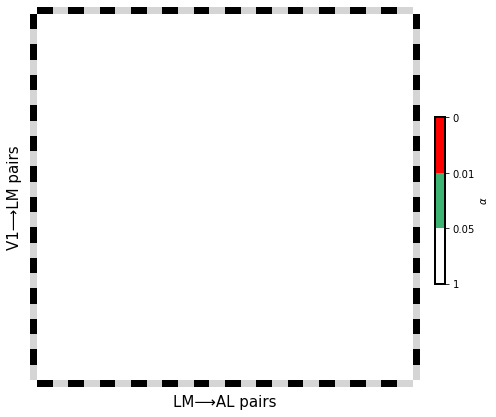

In [20]:
file_path = project_dir + 'Output/fig/session755434585_condtion24_filter_type_corr_FDRBY_LMhub_fixed_portion_kernel20ms_11282021_2128.png'
# model.plot_filter_memberships_corr(contingency_mat, chi2t_df, pval_df)
model.plot_filter_memberships_corr_beautiful(contingency_mat, chi2t_df, pval_df,level_order='10', multitest_method='fdr_by', file_path=file_path)
# model.plot_filter_memberships_corr_beautiful(contingency_mat, chi2t_df, pval_df,level_order='10', multitest_method=None, file_path=file_path)

#### Find out highlight neurons.

In [138]:
diag_neurons, bro_rec_neurons, diag_pairs, bro_rec_pairs = model.significant_pair_block_pattern_analysis(
        pval_df, contingency_mat, multitest_method='fdr_by', test_alpha=0.05, verbose=True)

Total:5	hub:0 (0.00000)	bro-rec:0 (0.00000)	sum:0	intersect:0
len(diag_pairs), len(bro_rec_pairs) 0 0


In [104]:
# Example contiengency table in the paper.
# ((951102686, 951108867), (951108867, 951112431),
tab = np.array([
         [36.,  4., 11.,  7.,  5.],
         [ 9.,  7., 13., 10.,  6.],
         [17., 13., 25., 12., 12.],
         [ 5.,  7., 13.,  7.,  9.],
         [13., 19., 12.,  6.,  7.]])

print(tab.sum(axis=0))
print(tab.sum(axis=1))
out = scipy.stats.chi2_contingency(tab, correction=True)
print(out[:3])

[80. 50. 74. 42. 39.]
[63. 45. 79. 41. 57.]
(49.06801858250299, 3.2232942387594487e-05, 16)


In [ ]:
LMs = bro_rec_pairs[(951103019, 951112780)]
V1LM, LMAL,_ = zip(*LMs)
_, LM_v1 = zip(*V1LM)
LM_al, _ = zip(*LMAL)
LM_v1 = set(LM_v1)
LM_al = set(LM_al)

print(len(LM_v1), len(LM_al))


#### Bootstrap to test contingency entry significance.

In [99]:
model.bootstrap_contingency_entries(tab, random_seed=123, num_samples=2000)

raw [[0.     0.006  0.062  0.176  0.0675]
 [0.115  0.3245 0.4    0.142  0.42  ]
 [0.1085 0.3605 0.172  0.4845 0.3965]
 [0.004  0.401  0.2705 0.411  0.114 ]
 [0.193  0.0025 0.1915 0.165  0.324 ]]
bonferroni [[0.     0.15   1.     1.     1.    ]
 [1.     1.     1.     1.     1.    ]
 [1.     1.     1.     1.     1.    ]
 [0.1    1.     1.     1.     1.    ]
 [1.     0.0625 1.     1.     1.    ]]
fdr_bh [[0.         0.0375     0.28125    0.32166667 0.28125   ]
 [0.31944444 0.4375     0.4375     0.32166667 0.4375    ]
 [0.31944444 0.4375     0.32166667 0.4845     0.4375    ]
 [0.03333333 0.4375     0.42265625 0.4375     0.31944444]
 [0.32166667 0.03125    0.32166667 0.32166667 0.4375    ]]
fdr_by [[0.         0.14309843 1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.12719861 1.         1.         1.         1.        ]
 [1.         0.11924869 1.         1.         1.        ]]


#### Contiengency tables.

contingency_table.shape (5, 5, 672, 648)
sig_contingency_table.shape (5, 5, 3566)
Total sample size: 285.0
CramerV all: 0.107	Sig:0.215


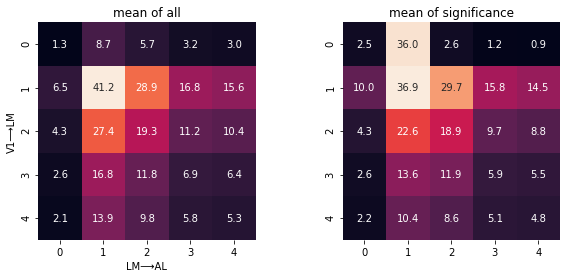

In [1035]:
file_path = project_dir + 'Output/fig/significant_contingency_pval0.05_fdrby.pdf'
model.plot_significant_contingency(filter_membership_CD, filter_membership_DE,
        contingency_mat, chi2t_df, pval_df, pval_threshold=0.05, file_path=None)

#### Portions of each group.

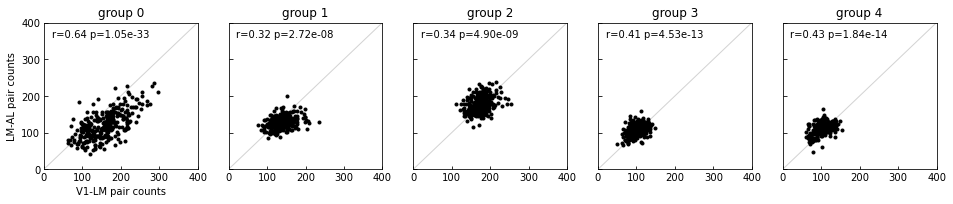

In [419]:
file_path = project_dir + 'Output/fig/cluster_cnt_corr.pdf'
model.plot_trial_to_trial_filter_memberships_cnt(filter_membership_CD, filter_membership_DE, file_path=None)

#### Network adjacency.

cluster membership cnt [(0, 727), (1, 593)]


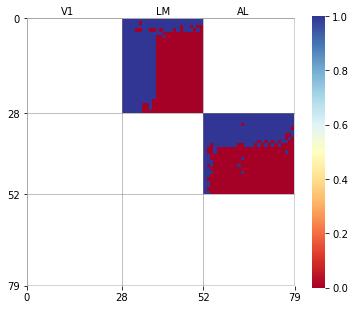

In [420]:
file_path = project_dir + 'Output/fig/significant_pair_adj.pdf'
model.plot_filter_memberships_significant_corr_adj(contingency_mat, chi2t_df, pval_df,
    pval_threshold=0.01, multitest_method='fdr_by', sort_nodes=True, file_path=None) 

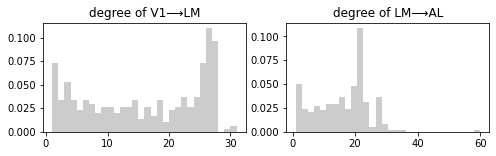

In [49]:
file_path = project_dir + 'Output/fig/significant_pair_adj.pdf'
model.plot_filter_memberships_significant_corr_subadj(contingency_mat, chi2t_df, pval_df,
    pval_threshold=1e-7, sort_nodes=True, file_path=None)

##### Load individual trial fits.

In [ ]:
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]
# select_itr = 5
condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
select_itr = 6

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
trial_ids = trials_df.index.values
print(trial_ids)
model_dir = project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19/'

prefix = 'group_model_pars_CD'
model_pars_list_CD = model.load_variable_list_across_trials(model_dir, prefix, trial_ids, max_itr=select_itr, verbose=False)
prefix = 'group_model_pars_DE'
model_pars_list_DE = model.load_variable_list_across_trials(model_dir, prefix, trial_ids, max_itr=select_itr, verbose=False)
prefix = 'filter_membership_CD'
filter_membership_list_CD = model.load_variable_list_across_trials(model_dir, prefix, trial_ids, max_itr=select_itr, verbose=False)
prefix = 'filter_membership_DE'
filter_membership_list_DE = model.load_variable_list_across_trials(model_dir, prefix, trial_ids, max_itr=select_itr, verbose=False)

In [ ]:
model.plot_trial_to_trial_filter_memberships_graph(filter_membership_list_CD, filter_membership_list_DE)

In [ ]:
model.plot_trial_to_trial_filter_memberships_adjvec_contrast(filter_membership_list_CD, filter_membership_list_DE)

In [ ]:
model.plot_trial_to_trial_betas(model_pars_list_CD, model_pars_list_DE)

# KS test --  goodness-of-fit test

In [2004]:
# for i, (neuron_x, neuron_y) in enumerate(filter_membership_DE.index):
#     if neuron_x % 3 == 0 and neuron_y % 3 == 0:
#         print(i, neuron_x, neuron_y)
for i, (neuron_x, neuron_y) in enumerate(filter_membership_CD.index):
    if neuron_x % 3 == 0 and neuron_y % 3 == 0:
        print(i, neuron_x, neuron_y)

240 951103290 951108540
244 951103290 951108867
250 951103290 951109137
253 951103290 951109191
255 951103290 951109299
258 951103290 951109338
259 951103290 951109329
312 951103332 951108540
316 951103332 951108867
322 951103332 951109137
325 951103332 951109191
327 951103332 951109299
330 951103332 951109338
331 951103332 951109329
336 951103380 951108540
340 951103380 951108867
346 951103380 951109137
349 951103380 951109191
351 951103380 951109299
354 951103380 951109338
355 951103380 951109329
384 951103488 951108540
388 951103488 951108867
394 951103488 951109137
397 951103488 951109191
399 951103488 951109299
402 951103488 951109338
403 951103488 951109329
408 951103530 951108540
412 951103530 951108867
418 951103530 951109137
421 951103530 951109191
423 951103530 951109299
426 951103530 951109338
427 951103530 951109329
432 951103632 951108540
436 951103632 951108867
442 951103632 951109137
445 951103632 951109191
447 951103632 951109299
450 951103632 951109338
451 951103632 95

240 951103290 951108540


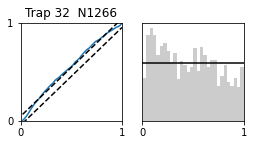

244 951103290 951108867


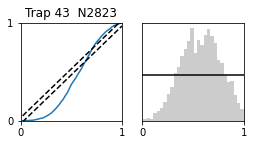

250 951103290 951109137


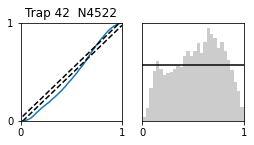

253 951103290 951109191


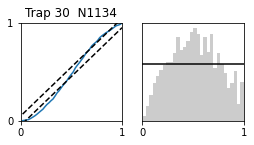

255 951103290 951109299


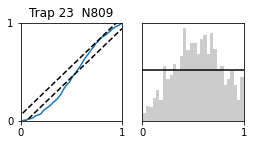

258 951103290 951109338


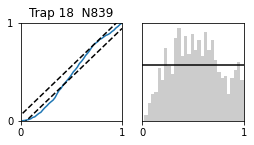

259 951103290 951109329


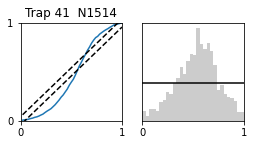

312 951103332 951108540


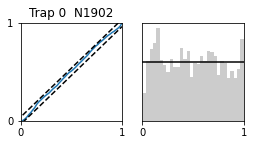

316 951103332 951108867


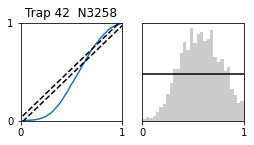

322 951103332 951109137


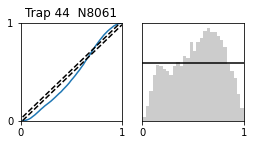

325 951103332 951109191


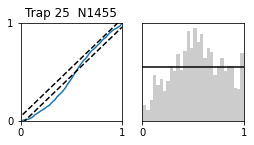

327 951103332 951109299


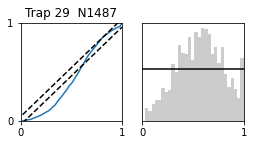

330 951103332 951109338


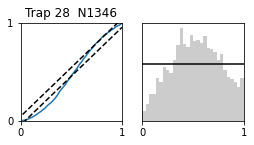

331 951103332 951109329


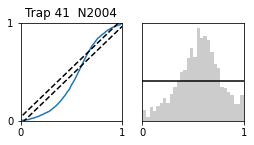

336 951103380 951108540


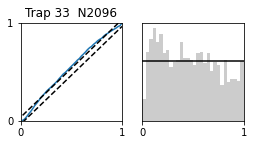

340 951103380 951108867


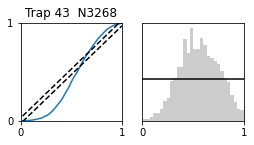

346 951103380 951109137


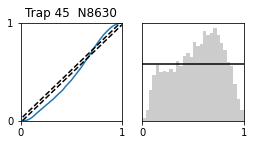

349 951103380 951109191


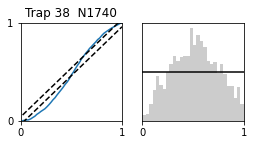

351 951103380 951109299


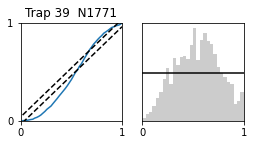

354 951103380 951109338


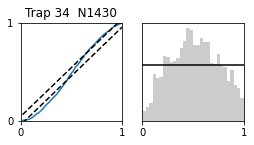

355 951103380 951109329


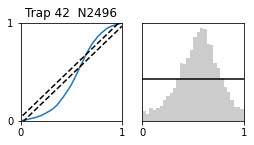

384 951103488 951108540


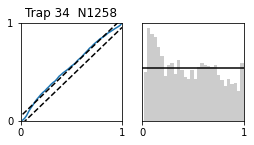

388 951103488 951108867


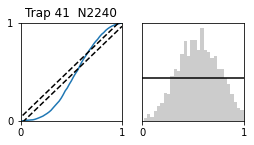

394 951103488 951109137


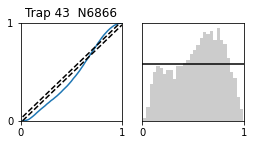

397 951103488 951109191


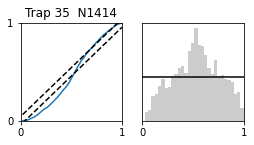

399 951103488 951109299


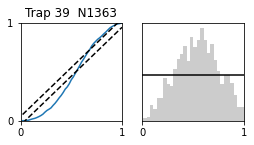

402 951103488 951109338


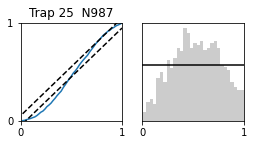

403 951103488 951109329


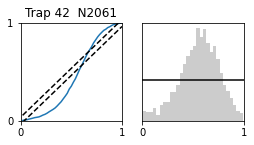

408 951103530 951108540


D:/Brain_Network/Code\jitter.py:4068: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4070: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4095: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:8267: RuntimeWarning: invalid value encountered in matmul
  lambda_hat = X @ beta


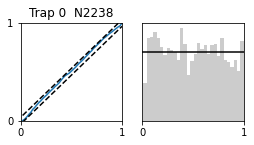

412 951103530 951108867


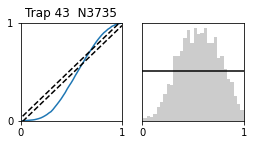

418 951103530 951109137


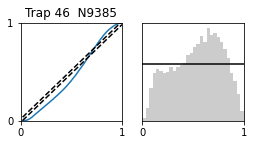

421 951103530 951109191


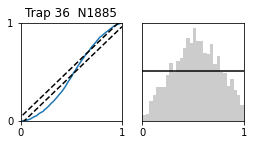

423 951103530 951109299


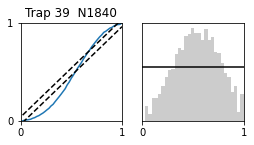

426 951103530 951109338


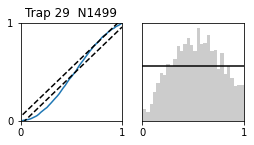

427 951103530 951109329


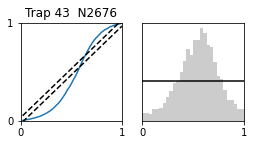

432 951103632 951108540


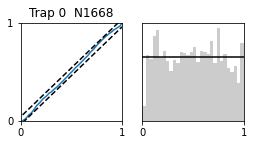

436 951103632 951108867


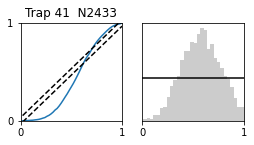

442 951103632 951109137


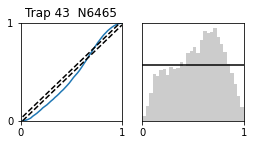

445 951103632 951109191


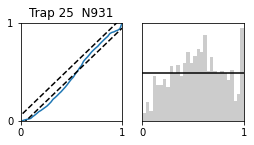

447 951103632 951109299


D:/Brain_Network/Code\jitter.py:4068: RuntimeWarning: invalid value encountered in matmul
  lmbd = X @ (beta + beta_offset) + offset
D:/Brain_Network/Code\jitter.py:4070: RuntimeWarning: invalid value encountered in matmul
  lmbd_integral = basis_integral.T @ (beta + beta_offset) + offset_integral
D:/Brain_Network/Code\jitter.py:4095: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
D:/Brain_Network/Code\jitter.py:8267: RuntimeWarning: invalid value encountered in matmul
  lambda_hat = X @ beta


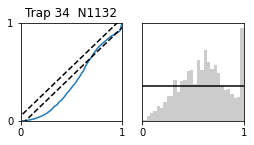

450 951103632 951109338


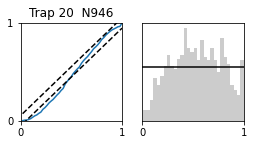

451 951103632 951109329


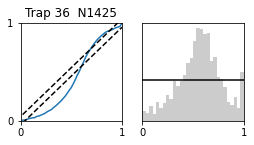

552 951103704 951108540


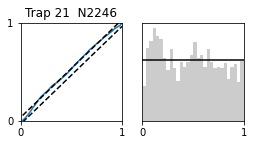

556 951103704 951108867


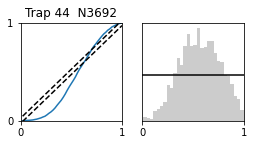

562 951103704 951109137


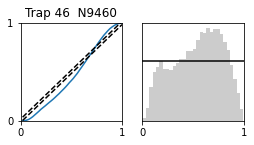

565 951103704 951109191


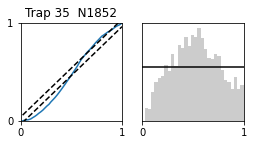

567 951103704 951109299


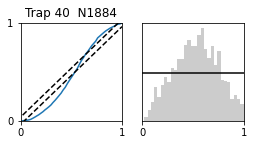

570 951103704 951109338


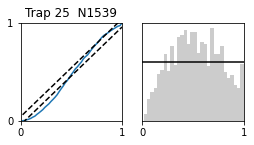

571 951103704 951109329


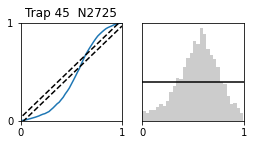

600 951104031 951108540


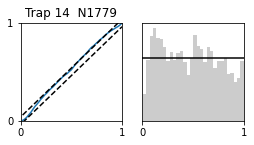

604 951104031 951108867


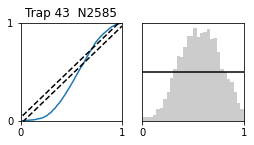

610 951104031 951109137


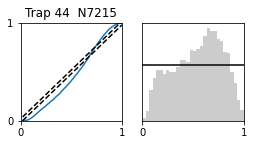

613 951104031 951109191


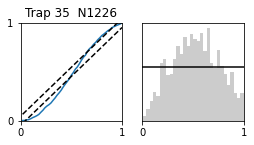

615 951104031 951109299


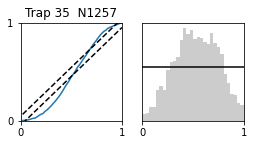

618 951104031 951109338


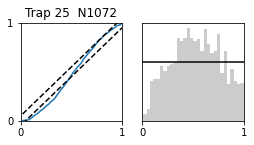

619 951104031 951109329


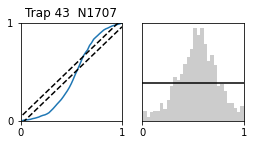

In [2006]:
u_list_dict = model.ks_test(spike_times, trial_window, group_model_pars, filter_membership_CD, selected_trial_ids[:], verbose=False)


In [2007]:
file_path = model_dir + f'CD_ks_test_u_list_dict_x3_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
util.save_variable(file_path, u_list_dict)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/CD_ks_test_u_list_dict_x3_20211123_213246.pkl


#### Plot all KS plots together.

In [2100]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'
# file_path = model_dir + 'CD_ks_test_u_list_dict_x3_20211123_213246.pkl'
file_path = model_dir + 'CD_ks_test_u_list_dict_20211123_144356.pkl'
u_list_dict_0 = util.load_variable(file_path)
file_path = model_dir + 'DE_ks_test_u_list_dict_20211123_192039.pkl'
u_list_dict_1 = util.load_variable(file_path)
u_list_dict = z = {**u_list_dict_0, **u_list_dict_1}

save figure: D:/Brain_Network/Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf


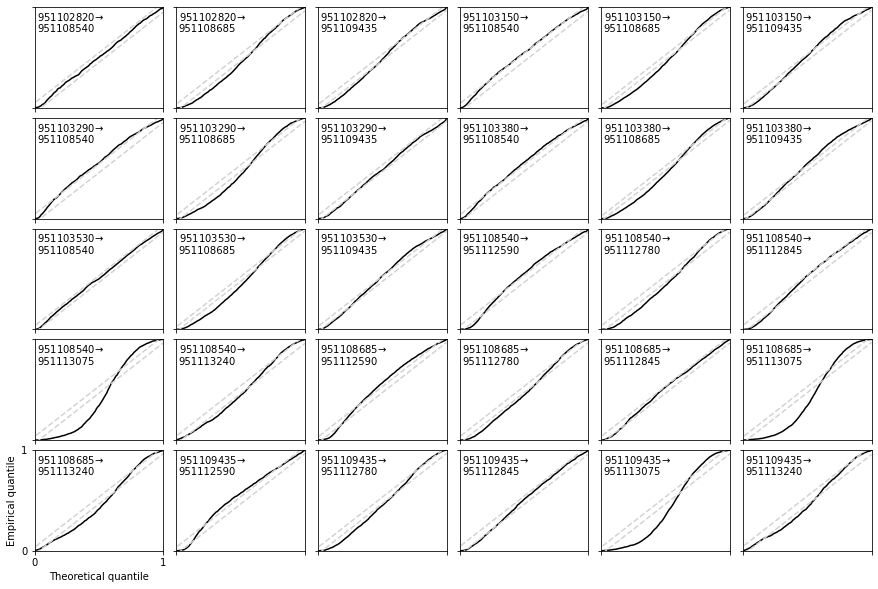

In [2102]:
file_path = project_dir + 'Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf'
model.plot_ks_u_list_dict(u_list_dict, test_size=0.01, file_path=file_path)

##### Debugging some errors.  951113075, 951113175 are weird. only one exception.
951109435 951113075

951108685 951113075

951108540 951113075

In [ ]:
u_list = u_list_dict[(951108685, 951108867)]
u_list = u_list[u_list > 0]
CI_trap, mcdf, ecdf, CI_up, CI_dn = jitter.JitterTool.check_ks(u_list, test_size=0.01, bin_width=0.02, verbose=True)

layers 2, nodes 1, trials 285
meanFR 9.219	meanISI 13.658


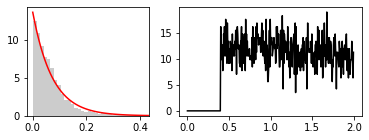

layers 2, nodes 1, trials 285
meanFR 7.337	meanISI 13.37


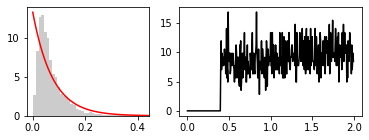

In [2053]:
spike_times_x = spike_times.loc[951108685,:].tolist()
spike_times_y = spike_times.loc[951108867,:].tolist()
jittertool.spike_times_statistics(spike_times_x, trial_length, verbose=True)
jittertool.spike_times_statistics(spike_times_y, trial_length, verbose=True)

In [2054]:
# model_par = {'filter_type': 'square', 'filter_length': 0.01,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par = {'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const',],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.1, 'filter_length': 0.4, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:], spike_times_y[:], [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par, generator_par, ylim=[-10,10])

num_trials 285
X.shape (4182, 2), basis_integral.shape (2, 1),beta.shape(2, 1)
  5%|███                                                          | 5/100 [00:00<00:00, 1252.48it/s]
gradient [-1.40994457e-05  4.99124144e-04]
num itr 5 [[-4171.97364895]] 1.870969451728266e-07
beta [7.33684209 0.08876699]
none filter type.


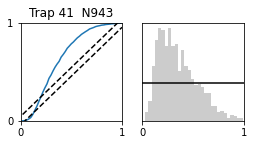

In [2055]:
model_par_ks_test = jittertool.ks_test(
        spike_times_x[:50], spike_times_y[:50], trial_window, model_par_hat, dt=0.001, test_size=0.05, verbose=True)


##### Discrete regression.

discrete integral    [[570.1425      -1.28517863]]
continuous integral  [[570.   0.]]
nuisance_y.shape (1140285, 1) nuisance_integral_y 0
num spikes x 5255 y 3674
X.shape (1140285, 3)
continuous integral  [[570.   0.]]
discrete integral    [[570.1425      -1.28517863   0.        ]]
itr0	nll: -3072.3	beta: [3.70080922 0.17864786 3.42085481]
itr1	nll: 1601.3	beta: [5.11669854 0.24819994 4.73410775]
itr2	nll: 1399.0	beta: [6.0645962  0.29511709 5.61501805]
itr3	nll: 1424.5	beta: [6.38645455 0.31099831 5.91403774]
itr4	nll: 1453.4	beta: [6.43840985 0.31355681 5.96227765]
itr5	nll: 1458.9	beta: [6.44407491 0.31383573 5.96753709]
itr6	nll: 1459.5	beta: [6.44464691 0.31386389 5.96806814]
itr7	nll: 1459.5	beta: [6.44470417 0.31386671 5.96812129]
itr8	nll: 1459.6	beta: [6.4447099  0.31386699 5.96812661]
itr9	nll: 1459.6	beta: [6.44471047 0.31386702 5.96812714]


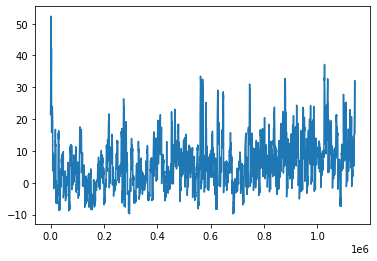

In [2047]:
model_par_discrete = {'dt': 0.0005, 'filter_type': 'none',
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par_discrete = {'dt': 0.0005, 'filter_type': 'square', 'filter_length': 0.03,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par_discrete = {'dt': 0.001, 'filter_type': 'bspline', 'num_knots': 3, 'knot_space_par': 0.1,
#         'filter_length': 0.05, 'num_tail_drop': 1,
#         'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.1,
#         'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_discrete_hat = jittertool.bivariate_discrete_time_coupling_filter_regression(
        spike_times_x, spike_times_y, trial_window, model_par_discrete, verbose=True)

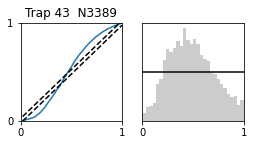

In [2025]:
model_par_ks_test = jittertool.ks_test(spike_times_x[:], spike_times_y[:], trial_window, model_par_discrete_hat, dt=0.001, test_size=0.05, verbose=True)


# Filter analysis.

#### No jitter.
Modify the model_par in the code.

In [ ]:
group_model_pars = model.update_cluster_filter_joint_trail(filter_membership_joint, batch_training=False, verbose=True)

In [953]:
file_path = (project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/' +
             f'group_model_pars_joint_itr13_nojitter_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
# util.save_variable(file_path, group_model_pars)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/group_model_pars_joint_itr13_nojitter_20210513-154649.pkl


Save figure to: D:/Brain_Network/Output/fig/condition19_filters_nojitter.pdf


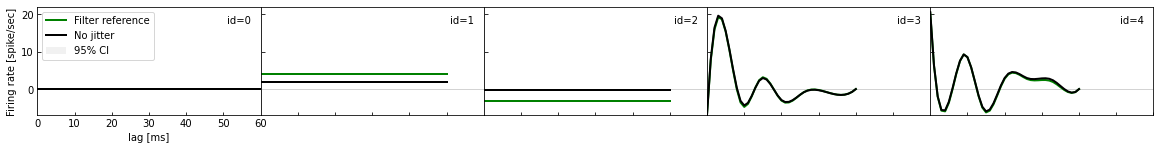

In [955]:
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/group_model_pars_joint_itr13_20210503-183429.pkl'
model_pars_ref = util.load_variable(model_path)
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/xxx.pkl'
model_pars_cnd = util.load_variable(model_path)

file_path = project_dir + 'Output/fig/condition19_filters_nojitter.pdf'
model.plot_multiple_filters(model_pars_cnd, model_pars_ref, ylim=[-7, 22], num_rows_cols=[1,5], file_path=None)

#### Fit the cluster using B-spline.

In [938]:
group_model_pars = model.update_cluster_filter_bspline(filter_membership_joint, batch_training=False, verbose=True)

#all trials:72106	#batch trials:72106


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

X.shape (951371, 10), basis_integral.shape (10, 1),beta.shape(10, 1)


 12%|███████▍                                                        | 7/60 [00:02<00:21,  2.46it/s]


num itr 7 [[-1058177.0468896]] 2.8631016131264175e-06
beta [ 8.09860818 -2.83679807  0.45636849 -2.0131476   0.71222905  2.83620997 -1.3302099   0.6913766   0.99357375
  0.45515677]
Finish 0.
#all trials:68171	#batch trials:68171


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

X.shape (1290177, 10), basis_integral.shape (10, 1),beta.shape(10, 1)


 12%|███████▍                                                        | 7/60 [00:03<00:29,  1.80it/s]


num itr 7 [[-1911851.24582546]] 9.34787481166044e-06
beta [10.67119659 -2.27729193  1.76835234 -1.46008894  2.15367066  4.6257441  -0.10450389  3.105501    2.13309431
  4.73171768]
Finish 1.
#all trials:115451	#batch trials:115451


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

X.shape (1806689, 10), basis_integral.shape (10, 1),beta.shape(10, 1)


 10%|██████▍                                                         | 6/60 [00:04<00:41,  1.30it/s]


num itr 6 [[-2315549.37985286]] 8.73953020696927e-06
beta [ 9.85644608 -1.48500088  0.16870381 -1.09102949  1.02443899  1.53495551 -0.55167848 -0.42972628  0.0659471
 -2.44781487]
Finish 2.
#all trials:52557	#batch trials:52557


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

X.shape (1271520, 10), basis_integral.shape (10, 1),beta.shape(10, 1)


100%|███████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.08it/s]
D:/Brain_Network/Code\jitter.py:3729: UserWarning: Reach max itrs 60. Last err:2.063e-04
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


num itr 59 [[-2218961.91323099]] 0.0002062784936867068
beta [ 14.48135653  -6.74366525  20.25592989  24.90710484 -14.37996267   9.5856256   -7.31581938   1.12561156
  -1.23976029  -2.16060087]
Finish 3.
#all trials:67915	#batch trials:67915


  0%|                                                                        | 0/60 [00:00<?, ?it/s]

X.shape (1456395, 10), basis_integral.shape (10, 1),beta.shape(10, 1)


100%|███████████████████████████████████████████████████████████████| 60/60 [00:32<00:00,  1.85it/s]

num itr 59 [[-2358338.94143715]] 0.0001266830986043077
beta [ 12.75873004  20.59851884  -4.95201786 -11.55445599  20.74271131 -15.80139788   8.65896081   0.79751486
   5.09119333  -2.8010959 ]
Finish 4.



D:/Brain_Network/Code\jitter.py:3729: UserWarning: Reach max itrs 60. Last err:1.267e-04
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


In [939]:
file_path = (project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/' +
             f'group_model_pars_joint_itr13_bspline_nojitter_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
# util.save_variable(file_path, group_model_pars)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/group_model_pars_joint_itr13_bspline_nojitter_20210513-110749.pkl


Save figure to: D:/Brain_Network/Output/fig/condition19_filters_bspline_nojitter.pdf


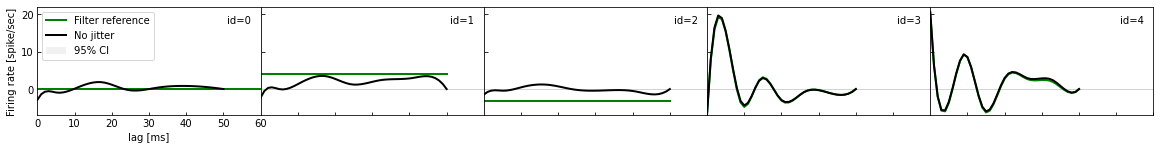

In [946]:
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/group_model_pars_joint_itr13_20210503-183429.pkl'
model_pars_ref = util.load_variable(model_path)
file_path = project_dir + 'Output/fig/condition19_filters_bspline_nojitter.pdf'
model.plot_multiple_filters(group_model_pars, model_pars_ref, ylim=[-7, 22], num_rows_cols=[1,5], file_path=None)

#### Fit all filters in each cluster grouped by neuron or trial.

In [ ]:
data_within = 'trial'
file_dir = project_dir + f'Output/fig/nuisance_regression_within_{data_within}/'
model_list = model.each_pair_all_trials_bivariate_regression(filter_membership_joint, data_within, model_par=None, verbose=True, file_dir=file_dir)

In [914]:
file_path = (project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/' +
             f'model_list_bspline_group_by_{data_within}_nojitter_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
util.save_variable(file_path, model_list)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/model_list_bspline_group_by_neuron_nojitter_20210512-153841.pkl


In [931]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/'
# file_path = model_dir + 'model_list_bspline_group_by_neuron_20210512-123650.pkl'
# file_path = model_dir + 'model_list_bspline_group_by_trial_20210512-121038.pkl'
file_path = model_dir + 'model_list_bspline_group_by_neuron_nojitter_20210512-153841.pkl'
# file_path = model_dir + 'model_list_bspline_group_by_trial_nojitter_20210512-144213.pkl'
model_list = util.load_variable(file_path)
model_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/group_model_pars_joint_itr13_20210503-183429.pkl'
group_model_pars = util.load_variable(model_path)

D:/Brain_Network/Code\jitter.py:3973: RuntimeWarning: invalid value encountered in sqrt
  h_std = np.sqrt(np.diag(h_var))
D:/Brain_Network/Code\jitter.py:3973: RuntimeWarning: invalid value encountered in sqrt
  h_std = np.sqrt(np.diag(h_var))


Save figure to: D:/Brain_Network/Output/fig/all_pairs_fit_group_by_neuron_nojitter.pdf


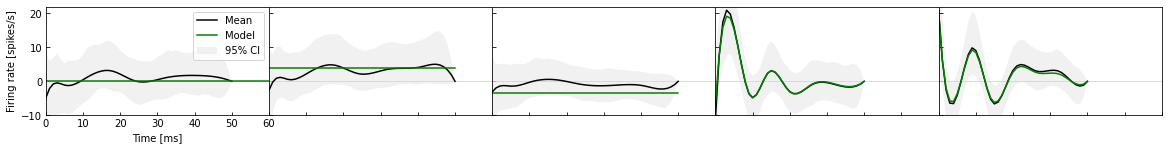

In [933]:
# file_path = project_dir + 'Output/fig/all_pairs_fit_group_by_neuron.pdf'
# file_path = project_dir + 'Output/fig/all_pairs_fit_group_by_trial.pdf'
file_path = project_dir + 'Output/fig/all_pairs_fit_group_by_neuron_nojitter.pdf'
# file_path = project_dir + 'Output/fig/all_pairs_fit_group_by_trial_nojitter.pdf'
model.plot_model_list_by_group_id(model_list, [0,1,2,3,4], group_model_pars, file_path=None)

#### Jitter re-fit.

In [959]:
model_pars_jitter_tuple = model.update_cluster_filter_jitter(filter_membership_joint, verbose=False)

filter_membership.shape (1320, 285)
#all trials:72106	#batch trials:72106
100%|█████████████████████████████████████████████████████████████| 100/100 [10:13<00:00,  6.14s/it]
Finish 0.
#all trials:68171	#batch trials:68171
100%|█████████████████████████████████████████████████████████████| 100/100 [14:00<00:00,  8.41s/it]
Finish 1.
#all trials:115451	#batch trials:115451
100%|█████████████████████████████████████████████████████████████| 100/100 [19:57<00:00, 11.97s/it]
Finish 2.
#all trials:52557	#batch trials:52557
  0%|                                                                       | 0/100 [00:00<?, ?it/s]

D:/Brain_Network/Code\jitter.py:3734: UserWarning: Reach max itrs 50. Last err:1.501e-03
  model_par['num_itrs'] = itr


100%|███████████████████████████████████████████████████████████| 100/100 [1:32:42<00:00, 55.63s/it]
Finish 3.
#all trials:67915	#batch trials:67915
  0%|                                                                       | 0/100 [00:00<?, ?it/s]

D:/Brain_Network/Code\jitter.py:3734: UserWarning: Reach max itrs 50. Last err:9.216e-04
  model_par['num_itrs'] = itr


100%|███████████████████████████████████████████████████████████| 100/100 [1:46:00<00:00, 63.60s/it]
Finish 4.


In [960]:
file_path = (project_dir + f'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/' +
             f'jitter_model_pars_tuple_itr13_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
util.save_variable(file_path, model_pars_jitter_tuple)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/model_pars_jitter_tuple_itr13_20210513-203412.pkl


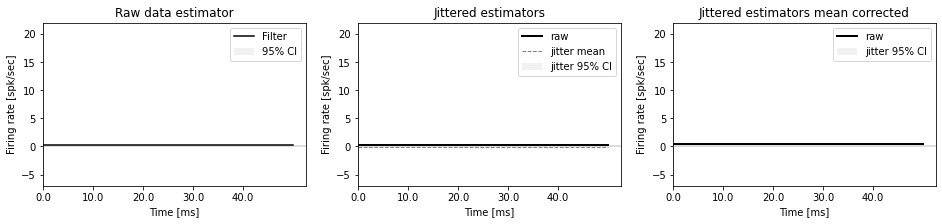

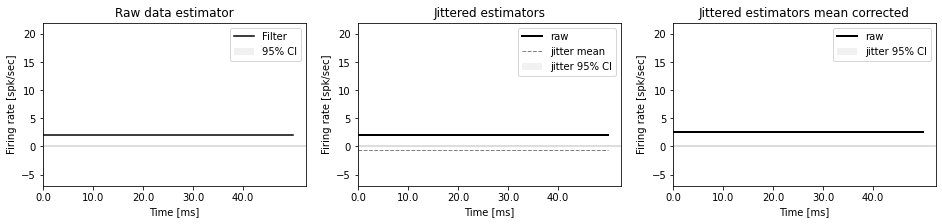

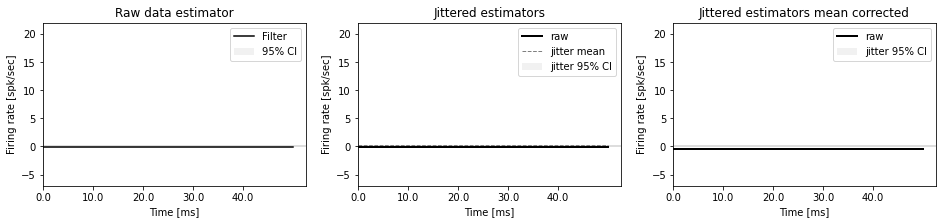

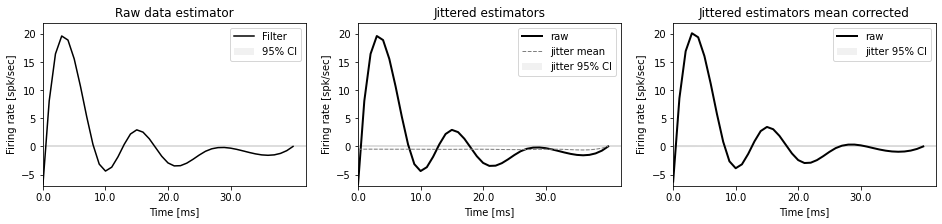

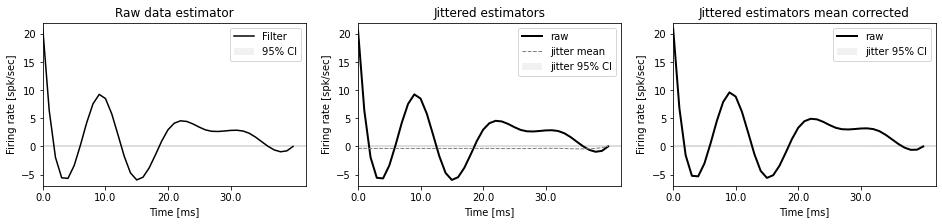

In [963]:
model_par_raw, model_par_jitter = model_pars_jitter_tuple[0]
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, ylim=[-7, 22])
model_par_raw, model_par_jitter = model_pars_jitter_tuple[1]
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, ylim=[-7, 22])
model_par_raw, model_par_jitter = model_pars_jitter_tuple[2]
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, ylim=[-7, 22])
model_par_raw, model_par_jitter = model_pars_jitter_tuple[3]
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, ylim=[-7, 22])
model_par_raw, model_par_jitter = model_pars_jitter_tuple[4]
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter, ylim=[-7, 22])

#### Jitter regression for individuals.

In [ ]:
data_within = 'trial'
file_dir = project_dir + f'Output/fig/jitter_regression_within_{data_within}/'
model.each_pair_all_trials_bivariate_regression_jitter(filter_membership_joint, data_within, verbose=True, file_dir=file_dir)

## Jitter CCG

layers 2, nodes 1, trials 285
meanFR 5.554	meanISI 19.692


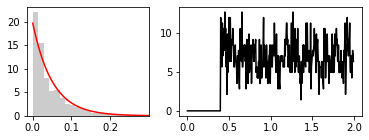

layers 2, nodes 1, trials 285
meanFR 5.382	meanISI 17.072


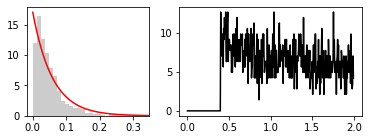

In [50]:
# (951102820 951112780)  (951103019, 951112780) (951102646 951112780)
spike_times_x = spike_times.loc[951103019,:].tolist()
spike_times_y = spike_times.loc[951112780,:].tolist()
jittertool.spike_times_statistics(spike_times_x, trial_length)
jittertool.spike_times_statistics(spike_times_y, trial_length)

In [1172]:
neuron_pairs = [(951102646 , 951112780)]  # 951102646 951112780
filter_membership_one = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)
for trial_id in selected_trial_ids:
    filter_membership_one = model.update_filter_membership(spike_times, trial_window, group_portion,
            group_model_pars, filter_membership_one, [trial_id], verbose=False)  
filter_membership_one

,,3798,3801,3810,3811,3813,3814,3816,3817,3819,3822,3824,3826,3828,3829,3831,3833,3835,3844,3845,3848,3852,3855,3859,3860,3862,3866,3870,3872,3875,3876,3878,3880,3881,3882,3884,3886,3888,3889,3895,3897,3898,3899,3900,3905,3906,3911,3912,3914,3917,3920,3921,3922,3924,3925,3928,3930,3932,3933,3934,3936,3937,3938,3942,3943,3944,3946,3947,3948,3949,3951,3953,3955,3956,3958,3959,3960,3962,3964,3966,3967,3968,3973,3979,3980,3981,3984,3986,3987,3988,3989,3992,3995,3996,3997,31002,31003,31004,31014,31015,31016,31020,31021,31022,31024,31026,31027,31028,31033,31034,31035,31039,31040,31043,31046,31047,31048,31051,31053,31054,31055,31056,31058,31062,31064,31066,31071,31072,31075,31076,31078,31079,31080,31081,31085,31086,31089,31093,31096,31098,31104,31105,31112,31114,31116,31125,31126,31129,31133,31135,31137,31142,31147,31148,31149,31151,31152,31154,31156,31159,31160,31161,31162,31165,31166,31167,31169,31170,31171,31172,31173,31174,31175,31177,31178,31179,31182,31184,31185,31186,31187,31188,31190,31191,31194,31196,31197,31199,31200,49206,49209,49211,49215,49217,49220,49223,49225,49226,49228,49230,49231,49232,49240,49245,49247,49250,49251,49253,49254,49255,49257,49260,49262,49263,49264,49266,49268,49274,49275,49277,49280,49281,49282,49286,49290,49299,49301,49304,49305,49307,49313,49316,49317,49320,49322,49323,49327,49328,49332,49335,49339,49340,49341,49344,49346,49349,49353,49354,49361,49364,49365,49367,49368,49370,49372,49374,49378,49380,49381,49383,49389,49390,49391,49394,49395,49399,49400,49401,49405,49407,49409,49410,49411,49412,49414,49415,49416,49418,49420,49422,49424,49426,49427,49428,49430,49431
951102646,951112780,3,0,0,0,2,3,2,2,0,0,0,0,0,1,4,4,1,0,0,0,3,1,4,1,0,4,0,0,0,0,1,0,4,3,0,3,0,0,3,0,4,2,0,0,0,0,4,4,0,0,0,2,2,1,0,0,0,0,3,0,1,1,0,0,0,0,4,0,1,4,0,0,0,0,0,0,2,0,2,4,0,0,0,0,0,2,3,0,4,0,0,3,0,3,0,0,3,0,0,0,0,0,0,0,1,0,0,0,2,0,0,3,1,0,3,4,2,0,0,0,0,4,3,0,0,0,2,0,2,1,4,0,0,1,1,3,0,0,1,4,2,0,4,2,4,0,0,2,0,0,4,2,0,4,4,1,2,0,2,0,0,0,0,0,0,0,2,0,0,0,4,3,0,0,1,0,0,0,0,0,0,0,0,0,3,3,2,1,3,0,0,0,0,2,1,0,0,0,0,0,0,0,2,3,4,3,2,0,4,0,0,0,0,1,0,0,3,0,4,0,3,4,2,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,3,0,3,0,0,2,0,3,1,0,0,0,0,0,0,0,4,0,0,0,0,0,4,4,0,0,0,0,3,0,0,2,0,0,0,3,2,0,4,0,4,0,4,1,0,2,1


In [56]:
jittertool = jitter.JitterTool()
trial_length = trial_window[1]
# filter_membership_sub = filter_membership_joint.iloc[:,[11]]  # group_id=2
# filter_membership_sub = filter_membership_joint.iloc[[9],:]  # group_id=2
# filter_membership_sub = filter_membership_joint.iloc[[17],:]  # group_id=2 951102476 951109307 # paper intro demo example.
filter_membership_sub = filter_membership_joint.loc[[(951102686, 951108867)],:]  # ((951102686, 951108867), (951108867, 951112431),
# filter_membership_sub = filter_membership_one

# Example contiengency table in the paper.
# ((951102686, 951108867), (951108867, 951112431),

spike_times_x, spike_times_y = model.stack_spike_times_by_pairs(spike_times, filter_membership_sub, group_id=2, verbose=False)
jittertool.spike_times_statistics(spike_times_x, trial_length,verbose=0)
jittertool.spike_times_statistics(spike_times_y, trial_length,verbose=0)
filter_membership_sub.T.value_counts()

layers 2, nodes 1, trials 79
meanFR 6.785	meanISI 9.693
layers 2, nodes 1, trials 79
meanFR 7.867	meanISI 12.589


(951102686, 951108867)
2.0                       79
0.0                       63
4.0                       57
1.0                       45
3.0                       41
dtype: int64

100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 393.19it/s]
Save figure to: D:/Brain_Network/Output/fig/pairs_951102476_951109307_group3_jwindow120ms_bin2ms.pdf


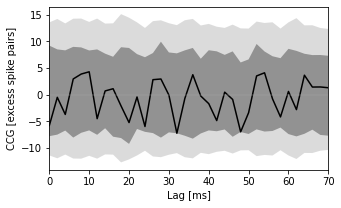

In [1351]:
trial_length = trial_window[1]
spk_bin_width = 0.002
lag_range = [0, 0.07]
jitter_window_width = 0.12
distribution_type='mc_sim'
num_jitter = 200

file_path = project_dir + f'Output/fig/pairs_951102476_951109307_group3_jwindow120ms_bin2ms.pdf'
_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, trial_length, lag_range, jitter_window_width,
        distribution_type, num_jitter, ci_alpha=0.05, file_path=file_path, verbose=True)

#### Coupling filter.

optimal kernel width  110.0


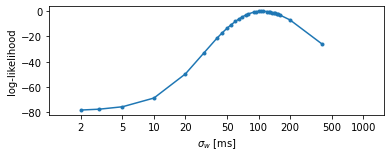

(array([0.002, 0.003, 0.005, 0.01 , 0.02 , 0.03 , 0.04 , 0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075,
        0.08 , 0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.12 , 0.125, 0.13 , 0.135, 0.14 , 0.145, 0.15 , 0.155,
        0.16 , 0.2  , 0.4  ]),
 array([-7.84340478e+01, -7.77493963e+01, -7.58327273e+01, -6.88999523e+01, -4.97294543e+01, -3.31444297e+01,
        -2.14190152e+01, -1.70836604e+01, -1.35172120e+01, -1.05687455e+01, -8.12777581e+00, -6.11524119e+00,
        -4.47272805e+00, -3.15365938e+00, -2.11787394e+00, -7.52528885e-01, -3.58001215e-01, -1.17048680e-01,
        -4.87959811e-03,  0.00000000e+00, -2.42206223e-01, -4.61457227e-01, -7.31575148e-01, -1.04408547e+00,
        -1.39203155e+00, -1.76972269e+00, -2.17247426e+00, -2.59630347e+00, -3.03792742e+00, -6.94042541e+00,
        -2.57497211e+01]))

In [2127]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par)
# model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
# jittertool.estimate_optimal_jitter_window_width_simple(spike_times_x, spike_times_y, model_par)

In [57]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.8, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.8, 'filter_length': 0.07, 'num_tail_drop': 1,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'square', 'filter_length': 0.05,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=True)


num_trials 79
X.shape (1243, 8), basis_integral.shape (8, 1),beta.shape(8, 1)
 67%|████████████████████████████████████████▏                   | 67/100 [00:00<00:00, 1400.67it/s]
gradient [ 1.81804342e-06 -4.52034531e-04  6.62359510e-07  1.12164743e-06 -5.74606240e-07 -4.29285163e-06
 -4.13586489e-06 -2.49900957e-06]
num itr 67 [[-1412.34976874]] 9.545179321335251e-06
beta [ 9.27486766  0.61265965 -5.23810573 -7.17483567 -3.61566111 -2.5668866  -0.47119242 -2.87701433]


filter integral [-0.20749001]
save figure: D:/Brain_Network/Output/fig/pairs_951102476_951109307_group2_bspline_kernelnone.pdf


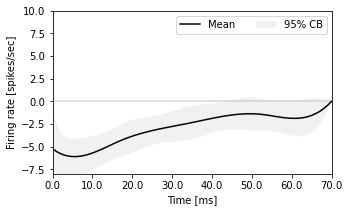

In [58]:
file_path = project_dir + f'Output/fig/pairs_951102476_951109307_group2_bspline_kernelnone.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-8,10], xlim=[0,0.07], file_path=file_path)

#### Simulation replication

In [2171]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'num_trials': 56, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 12, 'mu': 12, 'baseline': 1, 'window': 'gaussian', 'sigma': 0.04, 'random_seed': 0,
    'type': 'square', 'alpha': [[0., -5], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times_sim = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times_sim[1]
spike_times_y = spike_times_sim[0]

100%|███████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 36.26it/s]


optimal kernel width  45.0


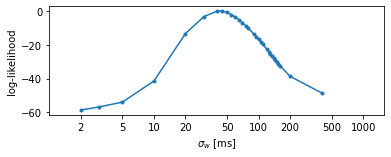

(array([0.002, 0.003, 0.005, 0.01 , 0.02 , 0.03 , 0.04 , 0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075,
        0.08 , 0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.12 , 0.125, 0.13 , 0.135, 0.14 , 0.145, 0.15 , 0.155,
        0.16 , 0.2  , 0.4  ]),
 array([-5.87454758e+01, -5.69014493e+01, -5.40107774e+01, -4.14952791e+01, -1.32895807e+01, -3.22690329e+00,
        -7.84663049e-03,  0.00000000e+00, -7.62793620e-01, -2.03987579e+00, -3.47845732e+00, -5.04402738e+00,
        -6.80031488e+00, -8.56971206e+00, -1.01919570e+01, -1.35005676e+01, -1.50479736e+01, -1.66920422e+01,
        -1.81780211e+01, -1.97510160e+01, -2.26561086e+01, -2.39883783e+01, -2.53819273e+01, -2.67209588e+01,
        -2.79067175e+01, -2.90430141e+01, -3.02175203e+01, -3.13332517e+01, -3.23115056e+01, -3.87174210e+01,
        -4.85322765e+01]))

In [2172]:
model_par = {'dt': 0.002, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par)
# model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'triangle_kernel']}
# jittertool.estimate_optimal_jitter_window_width(spike_times_x, spike_times_y, model_par)

In [2183]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.5, 'filter_length': 0.07, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.8, 'filter_length': 0.07, 'num_tail_drop': 1,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const'],
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 100, 'epsilon': 1e-6}
# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 1000, 'epsilon': 1e-6}
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, [0,trial_length], model_par, verbose=False)


filter integral [-0.25980959]


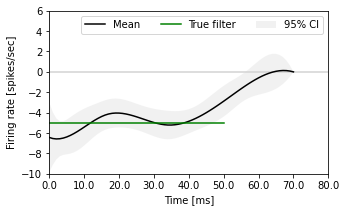

In [2184]:
file_path = project_dir + f'Output/fig/sim_trials56_kernelnone.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, xlim=[0,0.08], ylim=[-10,6], file_path=None)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.51it/s]
Save figure to: D:/Brain_Network/Output/fig/sim_trials56_jwindow120ms_bin2ms.pdf


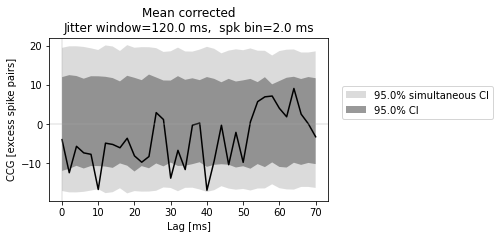

In [687]:
trial_length = trial_window[1]
spk_bin_width = 0.002
lag_range = [0, 0.07]
jitter_window_width = 0.12
distribution_type='mc_sim'
num_jitter = 1000

file_path = project_dir + f'Output/fig/sim_trials56_jwindow120ms_bin2ms.pdf'
_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, trial_length, lag_range, jitter_window_width,
        distribution_type, num_jitter, ci_alpha=0.05, file_path=file_path, verbose=True)

#### All trials or all neuron.

In [ ]:
data_within = 'trial'
file_dir = project_dir + f'Output/fig/ccg_within_{data_within}/'
model.each_pair_all_trials_ccg(filter_membership_joint, data_within, file_dir=file_dir)

# Other fitting strategies.

# Trial-wise fit.
Run clustering for each neuron on each trial. Run filter fitting within each trial separately.

In [10]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [1088]:
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
# select_condition_ids = [278, 267, 280, 256]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)


[ 3798  3801  3810  3811  3813  3814  3816  3817  3819  3822  3824  3826  3828  3829  3831  3833  3835  3844
  3845  3848  3852  3855  3859  3860  3862  3866  3870  3872  3875  3876  3878  3880  3881  3882  3884  3886
  3888  3889  3895  3897  3898  3899  3900  3905  3906  3911  3912  3914  3917  3920  3921  3922  3924  3925
  3928  3930  3932  3933  3934  3936  3937  3938  3942  3943  3944  3946  3947  3948  3949  3951  3953  3955
  3956  3958  3959  3960  3962  3964  3966  3967  3968  3973  3979  3980  3981  3984  3986  3987  3988  3989
  3992  3995  3996  3997 31002 31003 31004 31014 31015 31016 31020 31021 31022 31024 31026 31027 31028 31033
 31034 31035 31039 31040 31043 31046 31047 31048 31051 31053 31054 31055 31056 31058 31062 31064 31066 31071
 31072 31075 31076 31078 31079 31080 31081 31085 31086 31089 31093 31096 31098 31104 31105 31112 31114 31116
 31125 31126 31129 31133 31135 31137 31142 31147 31148 31149 31151 31152 31154 31156 31159 31160 31161 31162
 31165 31166 31167 

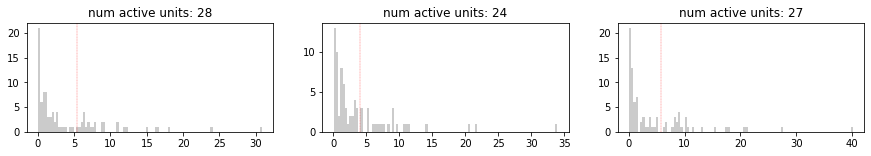

num_pairs: 672
num_pairs: 648


In [12]:
active_firing_rate_quantile_threshold = 0.7
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs)

In [ ]:
for trial_id in selected_trial_ids:
    trial_ids = [trial_id]
    file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
    group_model_pars_CD = util.load_variable(file_path)
    group_model_pars_DE = util.load_variable(file_path)
    print('trials', trial_ids)

    for itr in range(6):
        filter_membership_CD = model.update_filter_membership(group_model_pars_CD, filter_membership_CD, trial_ids, verbose=True)
        file_path = (project_dir + f'Output/jitter/coupling_filter/filter_membership_CD_trial{trial_id}_' +
                     f'itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
        util.save_variable(file_path, filter_membership_CD)
        graph_CD = model.build_neuron_graph(filter_membership_CD, verbose=1)
        group_model_pars_CD = model.update_cluster_filter(filter_membership_CD, trial_ids, batch_training=False, verbose=False)
        file_path = (project_dir + f'Output/jitter/coupling_filter/group_model_pars_CD_trial{trial_id}_' +
                     f'itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
        util.save_variable(file_path, group_model_pars_CD)
        model.plot_multiple_filters(group_model_pars_CD, ylim=[-6, 18], num_rows_cols=[1,5])

        filter_membership_DE = model.update_filter_membership(group_model_pars_DE, filter_membership_DE, trial_ids, verbose=True)
        file_path = (project_dir + f'Output/jitter/coupling_filter/filter_membership_DE_trial{trial_id}_' + 
                     f'itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
        util.save_variable(file_path, filter_membership_DE)
        graph_DE = model.build_neuron_graph(filter_membership_DE, verbose=1)
        group_model_pars_DE = model.update_cluster_filter(filter_membership_DE, trial_ids, batch_training=False, verbose=False)
        file_path = (project_dir + f'Output/jitter/coupling_filter/group_model_pars_DE_trial{trial_id}_' +
                     f'itr{itr}_{time.strftime("%Y%m%d-%H%M%S")}.pkl')
        util.save_variable(file_path, group_model_pars_DE)
        model.plot_multiple_filters(group_model_pars_DE, ylim=[-6, 18], num_rows_cols=[1,5])

# Trial-wise clustering. Separate baseline + joint filter (Not finished)
In the joint trial fit, I put all trial together assuming they have the same baseline/nuisance parameters.
Here I give each trial separate parameters but the filter parameters are the same.

In [27]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [28]:
# select_condition_ids = [275, 246, 268, 270, 284, 274,
#                         249, 263, 265, 261, 286, 258,
#                         278, 267, 280, 256, 260, 257, 281]
select_condition_ids = [275, 246, 268, 270]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3833  3835  3852  3855  3860  3882  3884  3898  3899  3914  3934  3938  3947  3951  3966  3979  3988
 31004 31016 31026 31040 31062 31072 31081 31086 31089 31104 31105 31114 31116 31135 31149 31160 31186 31197
 31200 49206 49231 49245 49250 49255 49274 49277 49281 49286 49299 49304 49316 49322 49327 49346 49372 49389
 49399 49409 49412 49415 49422 49427]


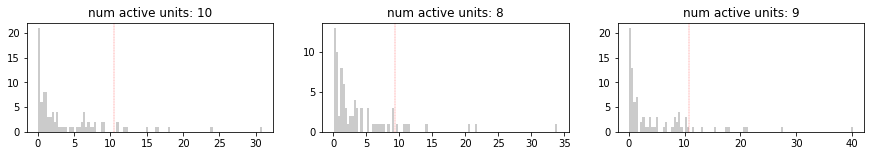

num_pairs: 80
num_pairs: 72


In [29]:
active_firing_rate_quantile_threshold = 0.9
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

##### Load existing memberships.

In [213]:
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/filter_membership_CD_itr12_20210503-165501.pkl'
# file_path = project_dir + 'Output/jitter/coupling_filter/filter_membership_CD_kernel50_condition19_20210506-085323.pkl'
filter_membership_CD = util.load_variable(file_path)
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit/filter_membership_DE_itr12_20210503-165501.pkl'
# file_path = project_dir + 'Output/jitter/coupling_filter/filter_membership_DE_kernel50_conditon19_20210506-085323.pkl'
filter_membership_DE = util.load_variable(file_path)

# filter_membership_CD = filter_membership_CD.iloc[:,[2]]
filter_membership_DE = filter_membership_DE.iloc[:,[2]]
print(filter_membership_CD.shape, filter_membership_DE.shape)
model.filter_membership_statistics(filter_membership_CD, verbose=True)
model.filter_membership_statistics(filter_membership_DE, verbose=True)
# filter_membership_joint = filter_membership_CD.append(filter_membership_DE)

(672, 285) (648, 1)
filter_membership.shape (672, 285)
membership cnt [(0.0, 40872), (1.0, 34841), (2.0, 58276), (3.0, 24730), (4.0, 32801)]
filter_membership.shape (648, 1)
membership cnt [(1.0, 126), (4.0, 148), (3.0, 110), (2.0, 179), (0.0, 85)]


[(1.0, 126), (4.0, 148), (3.0, 110), (2.0, 179), (0.0, 85)]

In [ ]:
for r in range(10):
    filter_membership_ = filter_membership_CD.iloc[:,[r]]
    group_model_pars = model.update_cluster_filter_trialwise_nuisance(filter_membership_CD, batch_training=False, verbose=True)
    print(group_model_pars[2]['beta'].T)

# Sampling inference (not finished)

In [11]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeC', 'probeD', 'probeE'], num_areas=3, verbose=False)

conditions: [(0, 246), (1, 249), (2, 256), (3, 257), (4, 258), (5, 260), (6, 261), (7, 263), (8, 265), (9, 267), (10, 268), (11, 270), (12, 274), (13, 275), (14, 278), (15, 280), (16, 281), (17, 284), (18, 286)]


In [488]:
# select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]
select_condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3798  3801  3810  3817  3819  3824  3826  3828  3833  3835  3844  3848  3852  3855  3860  3862  3875  3880
  3882  3884  3897  3898  3899  3906  3911  3912  3914  3917  3920  3924  3928  3933  3934  3938  3947  3949
  3951  3953  3955  3959  3960  3962  3964  3966  3968  3973  3979  3988  3992  3995  3996 31002 31004 31015
 31016 31020 31024 31026 31034 31039 31040 31047 31051 31053 31054 31055 31058 31062 31072 31079 31081 31085
 31086 31089 31093 31096 31098 31104 31105 31114 31116 31125 31129 31133 31135 31148 31149 31154 31156 31160
 31161 31162 31165 31167 31170 31177 31178 31179 31184 31185 31186 31187 31197 31199 31200 49206 49209 49223
 49226 49228 49230 49231 49232 49240 49245 49247 49250 49254 49255 49257 49262 49268 49274 49275 49277 49280
 49281 49286 49299 49301 49304 49313 49316 49317 49322 49327 49328 49332 49335 49339 49341 49346 49349 49361
 49365 49367 49372 49378 49383 49389 49395 49399 49400 49405 49407 49409 49412 49415 49416 49420 49422 49424
 49426 49427 49430]

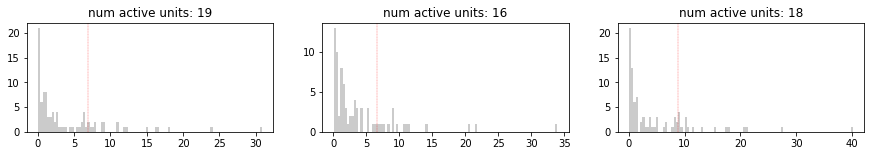

num_pairs: 304
num_pairs: 288


In [489]:
active_firing_rate_quantile_threshold = 0.8
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

probe_pairs = [('probeC', 'probeD')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_CD = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

probe_pairs = [('probeD', 'probeE')]
neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=probe_pairs, verbose=True)
filter_membership_DE = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids)

In [424]:
max_itrs = 7

file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
group_model_pars = util.load_variable(file_path)

for trial_id in tqdm(selected_trial_ids, ncols=100):
# trial_id = selected_trial_ids[0]
    trial_ids = [trial_id]
    filter_membership_CD = model.update_filter_membership(group_model_pars, filter_membership_CD, trial_ids, update_type='fit', verbose=0)

# filter_membership_DE = model.update_filter_membership(group_model_pars, filter_membership_DE, trial_ids, verbose=False)
model.filter_membership_statistics(filter_membership_CD, verbose=False)
# model.filter_membership_statistics(filter_membership_DE)

  0%|                                                                       | 0/120 [00:00<?, ?it/s]D:/Brain_Network/Code\jitter.py:3636: RuntimeWarning: overflow encountered in square
  hessian = X[non_zero_ind].T @ (X[non_zero_ind] / np.square(lmbd[non_zero_ind]))
 12%|███████▊                                                      | 15/120 [00:56<06:30,  3.72s/it]D:/Brain_Network/Code\jitter.py:3639: RuntimeWarning: invalid value encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
 21%|████████████▉                                                 | 25/120 [01:36<05:57,  3.77s/it]D:/Brain_Network/Code\jitter.py:3639: RuntimeWarning: overflow encountered in matmul
  delta = np.linalg.inv(hessian) @ gradient
 64%|███████████████████████████████████████▊                      | 77/120 [05:01<03:02,  4.24s/it]D:/Brain_Network/Code\jitter.py:3651: RuntimeWarning: invalid value encountered in subtract
  beta_err = np.sum(np.abs(beta_old - beta))
100%|████████████████████████████

[(0.0, 6377), (1.0, 6919), (2.0, 10860), (3.0, 5456), (4.0, 6868)]


# Coupling filter

##### Constant fitting.

In [394]:
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.06,
             'append_nuisance': ['const'],  'const_offset': 0,
             'learning_rate': 0.9, 'max_num_itrs': 20, 'epsilon': 1e-5}
model_par_hat12 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_window, model_par)
# model_par_hat21 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_y, spike_times_x, trial_length, model_par)

D:/Brain_Network/Code\jitter.py:3657: UserWarning: Reach max itrs 20. Last err:4.000e+00
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')


filter integral [-0.0122862]


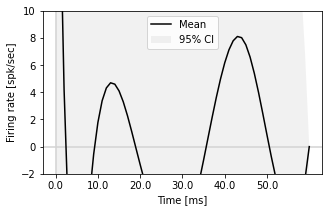

In [395]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat12, ylim=[-2, 10])
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat21, ylim=[-2, 5])

##### Approx jitter

In [1043]:
model_par = {'filter_type': 'bspline', 'num_knots': 18, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.05,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 20, 'epsilon': 1e-5}
model_par_hat12 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_time_window, model_par)
# model_par_hat21 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_y, spike_times_x, trial_length, model_par)

filter integral [0.0900578]


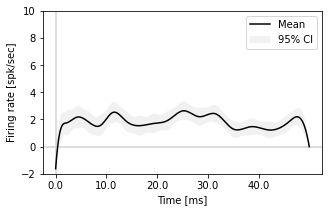

In [1044]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat12, ylim=[-2, 10])
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat21, ylim=[-5, 5])

Square window filter.

In [1341]:
model_par = {'filter_type': 'square', 'filter_length': 0.05,
             'append_nuisance': ['const', 'triangle_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 20, 'epsilon': 1e-5}
model_par_hat12 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_x, spike_times_y, trial_window, model_par)
# model_par_hat21 = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times_y, spike_times_x, trial_length, model_par)

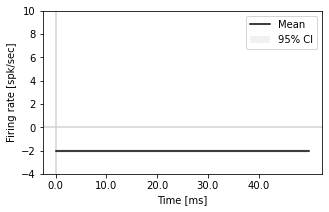

In [1342]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat12, ylim=[-4, 10])
# jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat21, ylim=[-5, 5])

#### Jitter coupling.

In [1024]:
model_par = {'filter_type': 'bspline', 'num_knots': 12, 'knot_space_par': 0.05, 'num_tail_drop': 1, 'filter_length': 0.04,
             'append_nuisance': ['const'], 'const_offset': 0,
             'num_jitter': 10, 'jitter_window_width': 0.1,
             'learning_rate': 0.9, 'max_num_itrs': 30, 'epsilon': 1e-5}
model_par_raw12, model_par_jitter12 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)
# model_par_raw21, model_par_jitter21 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
#     spike_times_y, spike_times_x, trial_time_window, model_par, verbose=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.20s/it]


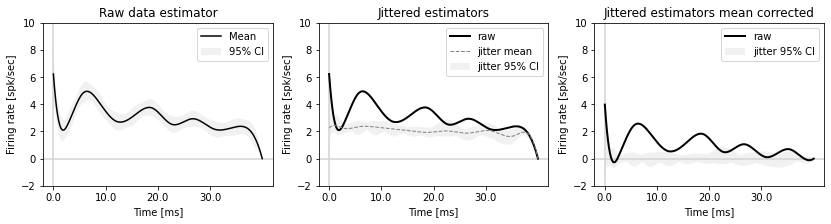

In [1025]:
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw12, model_par_jitter12, ylim=[-2, 10])
# jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw21, model_par_jitter21, ylim=[-10,50])

##### Jitter coupling constant.

In [432]:
model_par = {'filter_type': 'square', 'filter_length': 0.04,
             'append_nuisance': ['const'], 'const_offset': 0,
             'num_jitter': 10, 'jitter_window_width': 0.1,
             'learning_rate': 0.9, 'max_num_itrs': 30, 'epsilon': 1e-5}

model_par_raw12, model_par_jitter12 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)
# model_par_raw21, model_par_jitter21 = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
#     spike_times_y, spike_times_x, trial_time_window, model_par, verbose=True)

  0%|                                                                        | 0/10 [00:00<?, ?it/s]D:/Brain_Network/Code\jitter.py:3657: UserWarning: Reach max itrs 30. Last err:5.794e-03
  warnings.warn(f'Reach max itrs {max_num_itrs}. Last err:{beta_err:.3e}')
100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 668.68it/s]


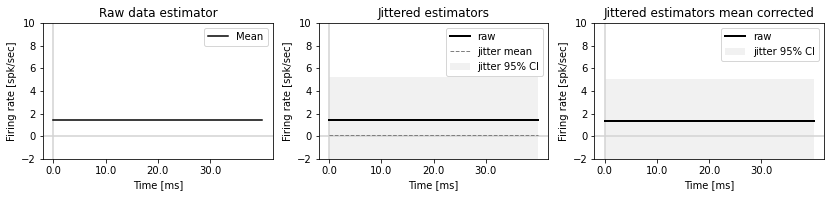

In [435]:
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw12, model_par_jitter12, ylim=[-2, 10])
# jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw21, model_par_jitter21, ylim=[-10,50])

# Other tests.

In [203]:
obs = np.array([[10, 10, 1], [20, 20, 0], [20, 20, 0]])

scipy.stats.chi2_contingency(obs, correction=True)

(3.8476190476190477,
 0.4270209830280963,
 4,
 array([[10.3960396 , 10.3960396 ,  0.20792079],
        [19.8019802 , 19.8019802 ,  0.3960396 ],
        [19.8019802 , 19.8019802 ,  0.3960396 ]]))

#### Multi-thread computing.

In [4]:
import joblib
from joblib import Parallel, delayed
number_of_cpu = joblib.cpu_count()
print(number_of_cpu)

def my_func(x, arr):
    time.sleep(0.2)
    arr[x] = x*2

# model = fine_time_coupling_model.FineTimeCouplingModel(session)

8


In [10]:
arr = np.zeros(50)
%time x = [my_func(i, arr) for i in range(len(arr))]
print(arr)

Wall time: 10 s
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50. 52.
 54. 56. 58. 60. 62. 64. 66. 68. 70. 72. 74. 76. 78. 80. 82. 84. 86. 88. 90. 92. 94. 96. 98.]


In [7]:
arr = np.zeros(50)
delayed_funcs = [delayed(my_func)(i, arr) for i in range(len(arr))]
with Parallel(n_jobs=10, verbose=4) as parallel_pool:
    %time outputs = parallel_pool(delayed_funcs)
print(arr)
# print(outputs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s


Wall time: 1.02 s
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[Parallel(n_jobs=10)]: Done  44 out of  50 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.9s finished


In [19]:
arr = np.zeros(50)
delayed_funcs = [delayed(my_func)(i, arr) for i in range(len(arr))]
with Parallel(n_jobs=10, verbose=2, prefer='processes', backend='threading', batch_size=10000) as parallel_pool:
    %time outputs = parallel_pool(delayed_funcs)
print(arr)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


Wall time: 1.02 s
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50. 52.
 54. 56. 58. 60. 62. 64. 66. 68. 70. 72. 74. 76. 78. 80. 82. 84. 86. 88. 90. 92. 94. 96. 98.]


[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.9s finished


### Parallel programming test.

In [255]:
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr11_20210520-083316.pkl'
filter_membership_CD = util.load_variable(file_path)
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr11_20210520-083316.pkl'
filter_membership_DE = util.load_variable(file_path)
z_CD = filter_membership_CD.iloc[:10,:30]
z_DE = filter_membership_DE.iloc[:10,:30]
selected_trial_ids = z_CD.columns.values
model.filter_membership_statistics(z_CD, verbose=True)
model.filter_membership_statistics(z_DE, verbose=True)

file_path = project_dir + 'Output/jitter/coupling_filter/group_model_pars_group5.pkl'
group_model_pars = util.load_variable(file_path)

filter_membership.shape (10, 30)
membership cnt [(0.0, 154.0), (1.0, 37.0), (2.0, 45.0), (3.0, 26.0), (4.0, 38.0)]
filter_membership.shape (10, 30)
membership cnt [(0.0, 58.0), (1.0, 44.0), (2.0, 101.0), (3.0, 50.0), (4.0, 47.0)]


In [244]:
x_CD = z_CD.copy()
x_DE = z_DE.copy()
for trial_id in tqdm(selected_trial_ids, ncols=100, file=sys.stdout):
    trial_ids = [trial_id]
    x_CD = model.update_filter_membership(spike_times, trial_window, group_model_pars, x_CD, trial_ids, verbose=False)
    x_DE = model.update_filter_membership(spike_times, trial_window, group_model_pars, x_DE, trial_ids, verbose=False)

  0%|                                                                         | 0/5 [00:00<?, ?it/s]

D:/Brain_Network/Code\jitter.py:3782: RuntimeWarning: overflow encountered in square
  hessian = X[non_zero_ind].T @ (X[non_zero_ind] / np.square(lmbd[non_zero_ind]))


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]


In [264]:
import joblib
from joblib import Parallel, delayed

jobs_CD = []
jobs_DE = []
for trial_id in selected_trial_ids:
    f1 = delayed(model.update_filter_membership)(spike_times, trial_window, group_model_pars, z_CD, [trial_id], parallel=True)
    f2 = delayed(model.update_filter_membership)(spike_times, trial_window, group_model_pars, z_DE, [trial_id], parallel=True)
    jobs_CD.append(f1)
    jobs_DE.append(f2)
print(len(delayed_funcs))

with Parallel(n_jobs=8, verbose=3) as parallel_pool:
    jobs_CD_out = parallel_pool(jobs_CD)
    jobs_DE_out = parallel_pool(jobs_DE)

w_CD = pd.concat(jobs_CD_out, axis=1)
w_DE = pd.concat(jobs_DE_out, axis=1)

10


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:   11.5s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    8.8s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    9.9s finished


In [246]:
print((x_CD != w_CD).sum().sum())
print((x_DE != w_DE).sum().sum())

0
0


In [211]:
trial_id = selected_trial_ids[0]
targetCD = x_CD.loc[:,trial_id].values
sourceCD = jobs_CD_out[1].loc[:,trial_id].values
targetDE = x_DE.loc[:,trial_id].values
sourceDE = jobs_DE_out[1].loc[:,trial_id].values
print(sum(targetCD != sourceCD), sum(targetDE != sourceDE))

13 26


In [209]:
for r, trial_id in enumerate(selected_trial_ids):
    targetCD = x_CD.loc[:,trial_id].values
    sourceCD = jobs_CD_out[r].loc[:,trial_id].values
    targetDE = x_DE.loc[:,trial_id].values
    sourceDE = jobs_DE_out[r].loc[:,trial_id].values
    print(sum(targetCD != sourceCD), sum(targetDE != sourceDE))

0 0
0 0
0 0
0 0
0 0


In [254]:
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr0_20210519-170336.pkl'
target_CD = util.load_variable(file_path)
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr0_20210519-170336.pkl'
target_DE = util.load_variable(file_path)

file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_CD_itr0_20210520-165803.pkl'
source_CD = util.load_variable(file_path)
file_path = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit2/filter_membership_DE_itr0_20210520-170523.pkl'
source_DE = util.load_variable(file_path)

print((target_CD != source_CD).sum().sum())
print((target_DE != source_DE).sum().sum())

0
0


In [523]:
A = [[1, 0],
     [0, 1]]
B = [[3, 4, 5],
     [6, 7, 8]]
C = [[7]]
P = np.zeros((2, 0), dtype='int32')
blocks = [A,P,B,C]
blocks = [A,B,C]
scipy.linalg.block_diag(*blocks)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 3, 4, 5, 0],
       [0, 0, 6, 7, 8, 0],
       [0, 0, 0, 0, 0, 7]], dtype=int32)

In [50]:
df = filter_membership_CD == 4
df.to_pickle(project_dir + 'Output/fast_oscillation.pkl')
unpickled_df = pd.read_pickle(project_dir + 'Output/fast_oscillation.pkl')